# Задача

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Описание услуг

Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
* Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
* Выделенная линия технической поддержки (Tech Support);
* Облачное хранилище файлов для резервного копирования данных (Online Backup);
* Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**
    
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
* contract — информация о договорах;
* personal — персональные данные клиентов;
* internet — информация об интернет-услугах;
* phone — информация об услугах телефонии.
    
Таблица telecom.contract
* customerID — ID абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.
    
Таблица personal
* customerID — ID пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.
    
Таблица telecom.internet
* customerID — ID пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.
    
Таблица telecom.phone
* customerID — ID пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.
    
Информация о договорах актуальна на 1 февраля 2020.

Перед началом проекта выполним установку и импорт необходимых библиотек и зададим константу RANDOM_STATE.

In [1]:
! pip install -q phik

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine 

import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn import metrics


import catboost as cb
from catboost import CatBoostClassifier, cv, Pool

import torch
import torch.nn as nn

In [3]:
RANDOM_STATE = 200224

## Подключение к базе. Загрузка таблиц sql

Создадим параметры подключения.

In [4]:
db_config = {
    'user': 'praktikum_student',# имя пользователя,
    'pwd': 'Sdf4$2;d-d30wp',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения,
    'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Выполним подключение.

In [5]:
engine = create_engine(connection_string) 

Далее выполним загрузку всех таблиц. Перед загрузкой каждой из таблиц будем проверять количество  строк и столбцов в ней. Если при проверке обнаружится, что таблица имееет большое количество данных, то выполнение их анализа будем проводить с помощью sql-запросов.

### Загрузка таблицы *contract*

Определим количество и названия столбцов.

In [6]:
query = '''
SELECT *
FROM telecom.contract
LIMIT 3
'''
pd.read_sql_query(query, con=engine)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15


Количество столбцов и их названия полностью соответствуют описанию, представленному в задаче. Определим количество строк.

In [7]:
query = '''
SELECT COUNT("customerID")
FROM telecom.contract;
'''
pd.read_sql_query(query, con=engine) 

,count
0,7043


Количество строк приемлено для чтения. Таким образом, загрузим наш датафрейм и для проверки результата выведем его первые пять строк.

In [8]:
query = '''
SELECT *
FROM telecom.contract;
'''
contract = pd.read_sql_query(query, con=engine) 

In [9]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Чтение и запись данных выполнены успешно.

### Загрузка таблицы *personal*

Определим количество и названия столбцов.

In [10]:
query = '''
SELECT *
FROM telecom.personal
LIMIT 3
'''
pd.read_sql_query(query, con=engine)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Количество столбцов и их названия полностью соответствуют описанию, представленному в задаче. Определим количество строк.

In [11]:
query = '''
SELECT COUNT("customerID")
FROM telecom.personal;
'''
pd.read_sql_query(query, con=engine) 

,count
0,7043


Количество строк приемлено для чтения. Таким образом, загрузим наш датафрейм и для проверки результата выведем его первые пять строк.

In [12]:
query = '''
SELECT *
FROM telecom.personal;
'''
personal = pd.read_sql_query(query, con=engine) 

In [13]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Чтение и запись данных выполнены успешно.

### Загрузка таблицы *internet*

Определим количество и названия столбцов.

In [14]:
query = '''
SELECT *
FROM telecom.internet
LIMIT 3
'''
pd.read_sql_query(query, con=engine)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


Количество столбцов полностью соответствуют описанию, представленному в задаче, при этом их названия внесены в первую строку датафрейма. После чтения потребуется откорректированть названия столбцов.

Определим количество строк.

In [15]:
query = '''
SELECT COUNT("c1")
FROM telecom.internet;
'''
pd.read_sql_query(query, con=engine) 

,count
0,5518


Количество строк приемлено для чтения. Таким образом загрузим наш датафрейм и сразу откорректируем названия столбцов. Для проверки результата выведем первые пять строк датафрейма.

In [16]:
query = '''
SELECT *
FROM telecom.internet;
'''
internet = pd.read_sql_query(query, con=engine) 

In [17]:
internet.columns = internet.loc[0]
internet.drop([0], inplace=True)
internet.reset_index(drop=True, inplace=True)
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Чтение и запись данных выполнены успешно.

### Загрузка таблицы *phone*

Определим количество и названия столбцов.

In [18]:
query = '''
SELECT *
FROM telecom.phone
LIMIT 3
'''
pd.read_sql_query(query, con=engine)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No


Количество столбцов полностью соответствуют описанию, представленному в задаче. При этом их названия внесены в первую строку датафрейма. После чтения потребуется откорректированть названия столбцов.

Определим количество строк.

In [19]:
query = '''
SELECT COUNT("c1")
FROM telecom.phone;
'''
pd.read_sql_query(query, con=engine) 

,count
0,6362


Количество строк приемлено для чтения. Таким образом загрузим наш датафрейм и сразу откорректируем названия столбцов. Для проверки результата выведем первые пять строк датафрейма.

In [20]:
query = '''
SELECT *
FROM telecom.phone;
'''
phone = pd.read_sql_query(query, con=engine) 

In [21]:
phone.columns = phone.loc[0]
phone.drop([0], inplace=True)
phone.reset_index(drop=True, inplace=True)
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Чтение и запись данных выполнены успешно.

## Исследовательский анализ данных

Анализ данных будем выполнять в следующей последовательности:
1. Выполним анализ данных отдельно по каждому датафрейму;
2. Объединим таблицы и сгенерируем дополнительные признаки;
3. Выполним дополнительный анализ данных объеденённого датафрейма.

### Анализ данных по каждому датафрейму

#### Анализ данных датафрейма *contract*

Выведем общую информацию о датафрейме,

In [22]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Из полученных данных мы видим, чтов датафрейме содержится 7043 строки. При этом, отмечается два столбца с пропусками:
1. EndDate - дата окончания действия договора. Вероятно, что наличие пропусков связано с тем, что договор не окончил действие;
2. TotalCharges - Общие расходы абонентов.
Далее проведём оценку данных по каждому столбцу.

##### Оценка столбца *customerID*

Из общей информации мы видели, что пропуска в столбце отсутствуют. Проверим в нём наличие дубликатов.

In [23]:
contract['customerID'].duplicated().sum()

0

Дубликаты в столбце отсутствуют. Дополнительно выведем на экрам произвольные 10 строк со значениями данного столбца для их визуальной оценки.

In [24]:
contract['customerID'].sample(10, random_state=RANDOM_STATE)

2747    4189-NAKJS
1394    8780-IXSTS
2918    5977-CKHON
1902    1680-VDCWW
5816    4254-QPEDE
4485    2880-FPNAE
6984    3078-ZKNTS
5530    5117-IFGPS
713     4283-FUTGF
2024    6582-OIVSP
Name: customerID, dtype: object

Мы видим, что уникальный номер клиента состоит из четырёхзначной цифры и пятизначного буквенного кода. Таким образом, данный столбец несёт только информацию об уникальном идентификаторе пользователя и по нему будет выполняться объединение таблиц.

##### Оценка столбца *BeginDate*

Выведем на экран статистическую информацию о данном столбце.

In [25]:
contract['BeginDate'].describe()

count           7043
unique           515
top       2019-03-24
freq              43
Name: BeginDate, dtype: object

Определим распределение дат.

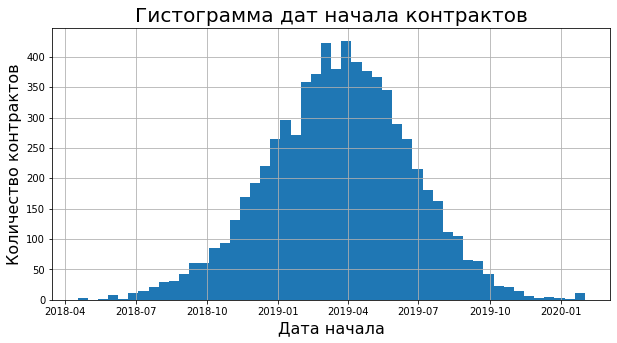

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
contract['BeginDate'].hist(bins=50)
plt.xlabel('Дата начала', fontsize=16)
plt.ylabel('Количество контрактов', fontsize=16)
plt.title('Гистограмма дат начала контрактов', fontsize=20)
plt.show()

Данные имеют нормальное распределение. Минимимальная граница дат не имеет выбросов. При этом из условий задачи мы знаем, что информация о договорах актуальноа на 1 февраля 2020 года. Таким образом проверим самую позднюю дату столбца.

In [27]:
contract['BeginDate'].max()

datetime.date(2020, 2, 1)

Из полученной информации заключаем, что выбросы в столбце отсутствуют.

##### Оценка столбца *EndDate*

Столбец EndDate определяет для нас целевой признак - закрыл ли клиент контракт или нет. Для начала проверим распределение дат.

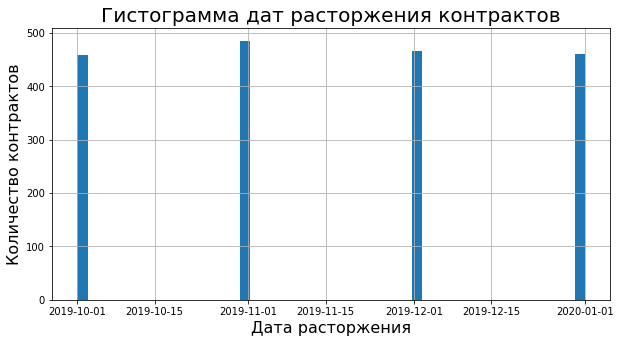

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
contract['EndDate'].hist(bins=50)
plt.xlabel('Дата расторжения', fontsize=16)
plt.ylabel('Количество контрактов', fontsize=16)
plt.title('Гистограмма дат расторжения контрактов', fontsize=20)
plt.show()

Мы видим, что закрытие договора происходит "дискретно" раз в месяц, что объясняется оплатой услуг "на перёд" ежемесячно. Стоит так же отметить, что в столбце имеются данные только, начиная с октября 2019 года, при этом данные по заключению договоров начинаются с апреля 2018.

Дополнительно подчеркнём, что на основе данного столбца:
1. Нам необходимо будет создать целевой признак. При этом учтём, что в случае если имеется дата окончания, то значит клиент разорвал договор. Если даты нет - договор не разорван.
2. На основе данного столбца и столбца "BeginDate" необходимо создать дополнительный признак - продолжительность предоставления услуг клиенту.

Данные имеют нормальное распределение. Минимимальная граница дат не имеет выбросов. При этом из условий задачи мы знаем, что информация о договорах актуальноа на 1 февраля 2020 года. Таким образом проверим самую позднюю дату столбца.

In [29]:
pd.to_datetime(contract['EndDate'], errors='coerce').max()

Timestamp('2020-01-01 00:00:00')

Из полученной информации заключаем, что выбросы в столбце отсутствуют.

##### Оценка столбца *Type*

Выведем на экран уникальные значения столбца.

In [30]:
contract['Type'].unique()

array(['Two year', 'Month-to-month', 'One year'], dtype=object)

У нас имеется всего три типа оплаты услуг, как и сказано в описании задачи. Проверим количество пользователей для каждого типа.

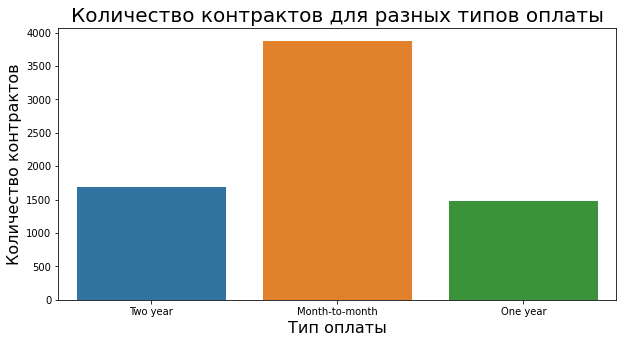

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=contract, x="Type")
plt.xlabel('Тип оплаты', fontsize=16)
plt.ylabel('Количество контрактов', fontsize=16)
plt.title('Количество контрактов для разных типов оплаты', fontsize=20)
plt.show()

Из полученных данных видно, что наибольшее количество договоров приходится на ежемесечную оплату. Примерно в два раза меньше приходится на годовую и полугодовую типы.

##### Оценка столбца *PaperlessBilling*

Выведем на экран уникальные значения столбца.

In [32]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

Аномалий в столбце не найдено. Проверим количество пользователей для каждого типа.

In [33]:
contract['PaperlessBilling'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

Из полученных данных видно, что около 60% пользователей имеют электронный счёт для оплаты услуг.

##### Оценка столбца *PaymentMethod*

Выведем на экран уникальные значения столбца.

In [34]:
contract['PaymentMethod'].unique()

array(['Bank transfer (automatic)', 'Mailed check', 'Electronic check',
       'Credit card (automatic)'], dtype=object)

Аномалий в столбце не найдено. Проверим количество пользователей для каждого типа.

In [35]:
contract['PaymentMethod'].value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64

Из полученных данных видно, что около 33% пользователей самостоятельно оплачивают услуги через интернет. По 22% пользователей приходится на пользователей, которые настроили автоматическую оплату и 23% выполняют оплату с получением почтового чека.

Дополнительно проверим, имеется ли зависимость между методом оплаты и наличием электронного счёта. Для этого выведем на экран сводную таблицу.

In [36]:
pd.pivot_table(contract, 
               index='PaymentMethod', 
               columns='PaperlessBilling', 
               values='customerID', 
               aggfunc='count'
              )

PaperlessBilling,No,Yes
PaymentMethod,,
Bank transfer (automatic),653,891
Credit card (automatic),640,882
Electronic check,623,1742
Mailed check,956,656


Из полученной таблицы можно сделать заключение, что если клиент не имеет электронного счёта, то скорее всего он получает чек по почте. Во всех остальных случаях наоборот.

Таким образом аномалий в исследуемом столбце не найдено.

##### Оценка столбца *MonthlyCharges*

Выведем на экран статистическую информацию о данном столбце.

In [37]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Определим распределение месечных расходов.

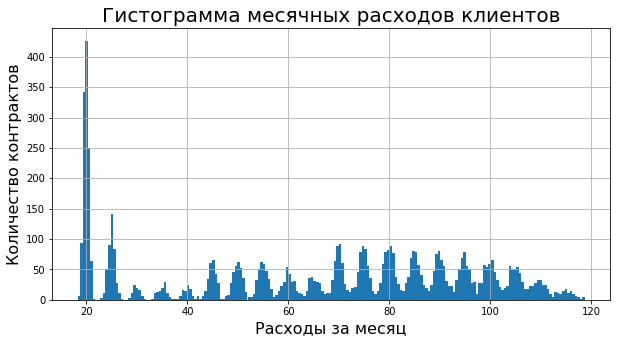

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
contract['MonthlyCharges'].hist(bins=200)
plt.xlabel('Расходы за месяц', fontsize=16)
plt.ylabel('Количество контрактов', fontsize=16)
plt.title('Гистограмма месячных расходов клиентов', fontsize=20)
plt.show()

Из полученной гистограммы видно что у нас имеется множество пиков самый большой из которых приходится на 20$ с дальнейшим резким снижением и далее плавными увеличением и снижением. На основе полученной гистограммы можно сделать следующие выводы:

1. Вероятнее всего, для клиентов доступна возможность получения дополнительных услуг и как правило они предлагаются с дискретностью 5$;
2. Большая часть пользователей покупает минимальное количество дополнительных услуг.

Таким образом, принимая во внимание полученные данные, можно сделать заключение, что анамалии в столбце отсутствуют.

##### Оценка столбца *TotalCharges*

Выведем на экран статистическую информацию о данном столбце.

In [39]:
contract['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

Определим распределение месячных расходов.

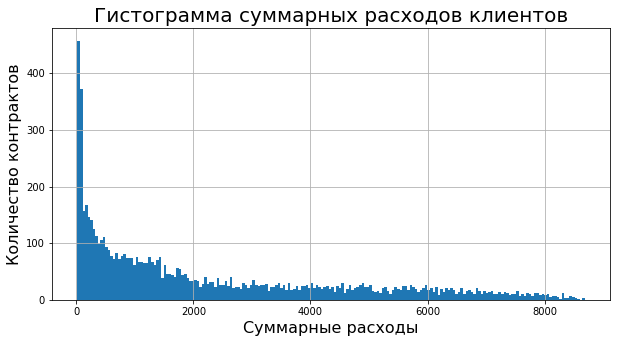

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
contract['TotalCharges'].hist(bins=200)
plt.xlabel('Суммарные расходы', fontsize=16)
plt.ylabel('Количество контрактов', fontsize=16)
plt.title('Гистограмма суммарных расходов клиентов', fontsize=20)
plt.show()

Из полученной гистограммы видно, что большое количество пользователей имеют минимальное значение сумарных дополнительных расходов. По мере увеличения значения расходов, количество пользователей снижается. При этом аномальных значений не найдено.

#### Анализ данных датафрейма *personal*

Выведем общую информацию о датафрейме,

In [41]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Из полученных данных мы видим, что в датафрейме содержится 7043 строк, что совпадает с датафреймом contract. Пропуска в столбцах отсутствуют.

Далее проведём оценку данных по каждому столбцу.

##### Оценка столбца *customerID*

Для данного столбца мы только проверим наличие дубликатов и посмотрим структуру уникального номера.

In [42]:
personal['customerID'].duplicated().sum()

0

In [43]:
personal['customerID'].sample(10, random_state=RANDOM_STATE)

2747    8295-FHIVV
1394    2272-JKMSI
2918    2761-XECQW
1902    1951-IEYXM
5816    0374-IOEGQ
4485    7975-JMZNT
6984    6447-GORXK
5530    9644-KVCNC
713     5433-KYGHE
2024    8272-ONJLV
Name: customerID, dtype: object

Дубликаты отсутствуют, а структура номера полностью соответствует структурее аналогичного столбца датафрейма contract. Таким образом, объединение таблиц будет выпонено по данному столбцу.

##### Оценка столбца *gender*

Выведем на экран уникальные значения столбца.

In [44]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [45]:
personal['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Гендерное соотношение клиентов можно считать равным.

##### Оценка столбца *SeniorCitizen*

Выведем на экран уникальные значения столбца.

In [46]:
personal['SeniorCitizen'].unique()

array([0, 1])

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [47]:
personal['SeniorCitizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

Из полученных данных видно, что примерно 16% клиентов - это пенсионеры.

##### Оценка столбца *Partner*

Выведем на экран уникальные значения столбца.

In [48]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [49]:
personal['Partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

Из полученных данных видно, что примерно 52% клиентов не имеют супруга/супруги.

##### Оценка столбца *Dependents*

Выведем на экран уникальные значения столбца.

In [50]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [51]:
personal['Dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

Из полученных данных видно, что примерно 70% клиентов не имеет детей.

#### Анализ данных датафрейма *internet*

Выведем общую информацию о датафрейме,

In [52]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Из полученных данных мы видим, что в датафрейме содержится 5517 строк, что меньше, чем в датафрейме contract. Пропуска в столбцах отсутствуют. Вероятнее всего в таблице отсутствуют данные клиентов, которые не пользовались ни одной услугой. Данное предположение будет проверено после объединения таблиц.

Далее проведём оценку данных по каждому столбцу.

##### Оценка столбца *customerID*

Для данного столбца мы только проверим наличие дубликатов и посмотрим структуру уникального номера.

In [53]:
internet['customerID'].duplicated().sum()

0

In [54]:
internet['customerID'].sample(10, random_state=RANDOM_STATE)

4787    0870-VEMYL
4690    5685-IIXLY
3162    5404-GGUKR
5313    5681-LLOEI
1570    8000-REIQB
3209    0641-EVBOJ
4556    4976-LNFVV
3778    8993-IZEUX
1685    3023-GFLBR
866     7241-AJHFS
Name: customerID, dtype: object

Дубликаты отсутствуют, а структура номера полностью соответствует структурее аналогичного столбца датафрейма contract. Таким образом, объединение таблиц будет выпонено по данному столбцу.

##### Оценка столбца *InternetService*

Выведем на экран уникальные значения столбца.

In [55]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [56]:
internet['InternetService'].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

Мы видим, что 56% клиентов подключили использование оптической системы передачи данных.

##### Оценка столбца *OnlineSecurity*

Выведем на экран уникальные значения столбца.

In [57]:
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [58]:
internet['OnlineSecurity'].value_counts(normalize=True)

No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

Мы видим, что только 36% клиентов подключили услугу блокировки опасных сайтов.

##### Оценка столбца *OnlineBackup*

Выведем на экран уникальные значения столбца.

In [59]:
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [60]:
internet['OnlineBackup'].value_counts(normalize=True)

No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

Мы видим, что 44% клиентов подключили услугу облочного хранения данных.

##### Оценка столбца *DeviceProtection*

Выведем на экран уникальные значения столбца.

In [61]:
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [62]:
internet['DeviceProtection'].value_counts(normalize=True)

No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

Мы видим, что 44% клиентов подключили услугу антивируса.

##### Оценка столбца *TechSupport*

Выведем на экран уникальные значения столбца.

In [63]:
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [64]:
internet['TechSupport'].value_counts(normalize=True)

No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

Мы видим, что только 37% клиентов подключили выделенную линию технической поддержки.

##### Оценка столбца *StreamingTV*

Выведем на экран уникальные значения столбца.

In [65]:
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [66]:
internet['StreamingTV'].value_counts(normalize=True)

No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

Мы видим, что примерно половина клиентов подключили стриминговое телевидение.

##### Оценка столбца *StreamingMovies*

Выведем на экран уникальные значения столбца.

In [67]:
internet['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [68]:
internet['StreamingMovies'].value_counts(normalize=True)

No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64

Мы видим, что примерно половина клиентов подключили стриминговые фильмы.

#### Анализ данных датафрейма *phone*

Выведем общую информацию о датафрейме,

In [69]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Из полученных данных мы видим, что в датафрейме содержится 6361 строка, что меньше, чем в датафрейме contract. Пропуска в столбцах отсутствуют. 

Далее проведём оценку данных по каждому столбцу.

##### Оценка столбца *customerID*

Для данного столбца мы только проверим наличие дубликатов и посмотрим структуру уникального номера.

In [70]:
phone['customerID'].duplicated().sum()

0

In [71]:
phone['customerID'].sample(10, random_state=RANDOM_STATE)

457     5956-VKDTT
1835    6845-RGTYS
2342    7996-BPXHY
1931    7707-PYBBH
4384    8348-JLBUG
4608    7159-NOKYQ
217     4522-AKYLR
4886    5376-DEQCP
3724    1919-RTPQD
4835    3143-JQEGI
Name: customerID, dtype: object

Дубликаты отсутствуют, а структура номера полностью соответствует структурее аналогичного столбца датафрейма contract. Таким образом, объединение таблиц будет выпонено по данному столбцу.

##### Оценка столбца *MultipleLines*

Выведем на экран уникальные значения столбца.

In [72]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Аномалий в столбце не найдено. Проверим соотношение количества пользователей для каждого типа.

In [73]:
phone['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

Мы видим, что 47% клиентов подключили телефон к нескольким линиям одновременно.

#### **Выводы**
1. По результатам оценки данных таблицы *contract* установлено:
    1. Аномальных значений в столбцах датафрейма не найдено;
    2. Пропуска в данных имеются в следующих столбцах:
        * Столбец *EndDate* с датой окончания действия договора;
        * Столбец *TotalCharges*;
    3. По данным столбца *EndDate* необходимо сформировать столбец с целевым признаком *termination*, а также дополнительный исходный признак - продолжительность *use_days*. При этом, для формирования столбца *TotalCharges* пропуска в столбце *EndDate* будут заменены на дату актуальности таблицы (01.02.2020).
    4. Пропуска в столбце *TotalCharges* необходимо попытаться заполнить, проведя дополнительный анализ после объединения всех таблиц. В случае невозможности заполнения мы их удалим, так как их очень мало (всего 11 строк)
2. По результатам оценки данных таблиц *contract*, *internet* и *phone* установлено:
    1. Аномальных значений в столбцах датафреймов не найдено;
    2. Пропуска в данных отсутствуют;
    3. Все столбцы признаки в датафрейме бинарные.
3. Объединение всех таблиц будем выполнять по общему столбцу *customerID*. Структура номера для данного столбца во всех таблицах одинакова. 


### Объединение датафреймов и расчёт дополнительных признаков

#### Объединение датафреймов

Выполним объединение всех датафреймов и для проверки выведем на экран общую информацию о нём.

In [74]:
df = pd.merge(contract, personal, on="customerID", how='outer')
df = pd.merge(df, internet, on="customerID", how='outer')
df = pd.merge(df, phone, on="customerID",  how='outer')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Объединение таблиц выполнено успешно. Стоит отметить, что итоговое количество строк соответствует количеству строк в исходном датафрейме *contract*.

Далее выполним расчёт дополнительных признаков.

#### Расчёт дополнительных столбцов признаков

Первоначально расчитаем столбец с целевым признаком *termination*. Для этого создадим функцию *target_make* и применим её к датафрейму.

In [76]:
def target_make(row):
    if row['EndDate'] is None:
        return 0
    return 1

In [77]:
df['termination'] = df.apply(target_make, axis=1)

Оценим результат и сразу определим дисбаланс классов по целевому признаку.

In [78]:
df['termination'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: termination, dtype: float64

Мы видим, что датафрейм имеет большой дисбаланс по целевому признаку. Однако, принимая во внимание, что по условиям задачи нам необходимо обеспечить параметр ROC-AUC, выполнение подбора порога производится не будет.

Далее создадим дополнительный столбец *use_days* для с количеством дней предоставления услуг пользователю. Для проверки результата выведем на экран первые пять строк детефрейма и общую статистическую информацию о столбце.

In [79]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['EndDate'] = df['EndDate'].fillna(pd.to_datetime('01-02-2020', format='%d-%m-%Y'))
df['use_days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [80]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,termination,use_days
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,1,279


In [81]:
df['use_days'].describe()

count    7043.000000
mean      297.378674
std        83.868181
min         0.000000
25%       242.000000
50%       298.000000
75%       351.000000
max       583.000000
Name: use_days, dtype: float64

#### **Выводы**

По результатам выполнения пункта:
1. Выполнено объединения датафреймов в один. Количество столбцов итогового датафрейма совпало с количеством столбцов датафрейма *contract*;
2. Созданы два дополнительных столбца:
    * Столбец с целевым признаком *termination*;
    * Дополнительный столбец признак *use_days* с количеством дней предоставления услуг пользователю.

### Анализ данных результирующего датафрейма

Повторный анализ данных будем выполнять в следующей последовательности:
1. Выполним отельный анализ столбцов с пропусками и примим решения по их заполнению;
2. Выполним визуализацию соотношений ушедших и оставшихся клиентов для каждого признака;
3. Выполним оценку Фк-корелляции параметров.

#### Анализ столбцов с пропусками

Первоначально, выведем на экран количество пропусков по каждому столбцу.

In [82]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
termination            0
use_days               0
dtype: int64

Далее будем выполнять анализ по тем столбцам, в которых имеются пропуска.

##### Анализ столбца *TotalCharges*

Так как количество пропусков в столбце достаточно мало, выведем на экран строки с пропусками в исследуемом столбце и посмотрим  данные вручную.

In [83]:
df.loc[df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,termination,use_days
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
10,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,...,DSL,Yes,Yes,No,Yes,No,No,Yes,0,0
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0


Из полученного датафрейма видно, что пропуска содержатся для пользователей которые заключили договор в день актуализации таблицы. Такие строки не будут нести для нашей модели какой-либо полезной информации, поэтому удалим их из датафрейма, предварительно проверив количество клиентов с датой заключения договора 01 февраля 2020 года.

In [84]:
df.query('BeginDate=="2020-02-01"')['customerID'].count()

11

Таких клиентов только 11, что совпадает с количеством пропусков в столбце *TotalCharges*. Удалим данные строки из датафреймов.

In [85]:
df.dropna(subset=['TotalCharges'], inplace=True)

##### Анализ столбцов с информацией о подключенных услугах.

Большое количество пропусков в датафрейме мы полчили по столбцам, взятых из таблицы *internet*, где представлена нформация об услугах, которые подключили пользователи. Возможно, что пользователи, которые не подключили ни одной услуги не вошли в данную таблицу и пропуска связаны именно с этим. Попробуем посмотреть, имеются ли среди пользователей такие, кто не подключил ни одной услуги, но в таблице он присутствует. Для этого создадим функцию *connecting_services_make* для поиска таких клиентов и применим её к датафрейму. Если клиент не подключал ни одной услуги, но данные о нём имеются, то функция будет возвращять 1, иначе - 0.

In [86]:
def connecting_services_make(row):
    if row['InternetService'] == 'DSL' and \
       row['OnlineSecurity'] == 'No' and \
       row['OnlineBackup'] == 'No' and \
       row['DeviceProtection'] == 'No' and \
       row['TechSupport'] == 'No' and \
       row['StreamingTV'] == 'No' and \
       row['StreamingMovies'] == 'No':
        return 1
    return 0

In [87]:
df['connecting_services'] = df.apply(connecting_services_make, axis=1)

Проверим результат и выведем на экран количество клиентов по столбцу *connecting_services*

In [88]:
df['connecting_services'].value_counts()

0    6738
1     294
Name: connecting_services, dtype: int64

Из полученных данных видно, что в таблице имеются клиенты, которые не подключали ни каких услуг, но данные по ним имеются. Наше предположение не подтвердилось.

С учётом полученной информации заполнение пропусков в рассматриваемых столбцах заполним значением "no_info".

##### Анализ столбца *MultipleLines*

Чтобы заполнить пропущенные значения попробуем найти какие-либо зависимости между имеющимся столбцом и иными признаками. Для этого выведем на экран диаграммы с перекрёсной оценкой признаков.

In [89]:
cat_cols = df.drop(columns=['customerID', 'MultipleLines','BeginDate', 'EndDate','MonthlyCharges', 'TotalCharges', 'use_days']).columns.tolist()
num_cols = ['MonthlyCharges', 'TotalCharges', 'use_days']

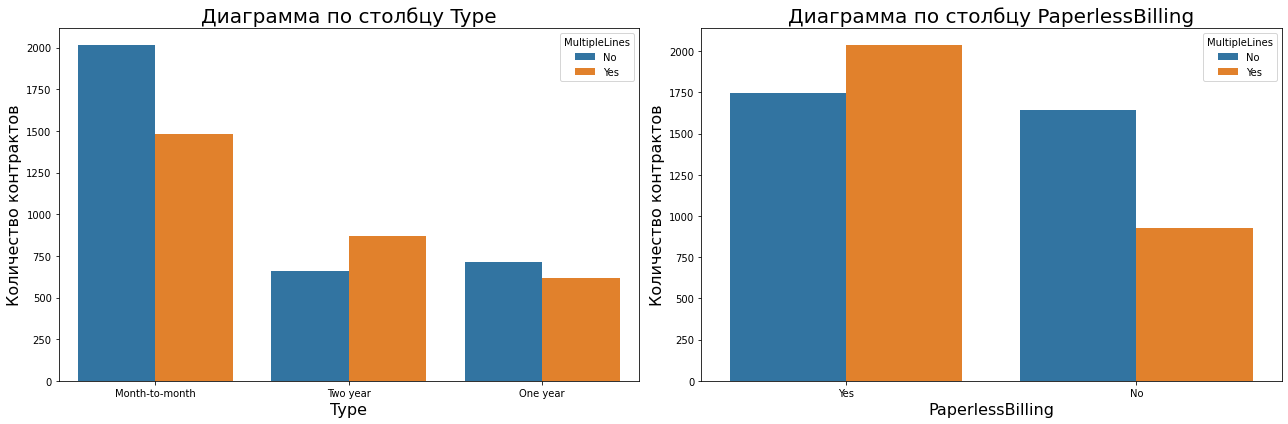

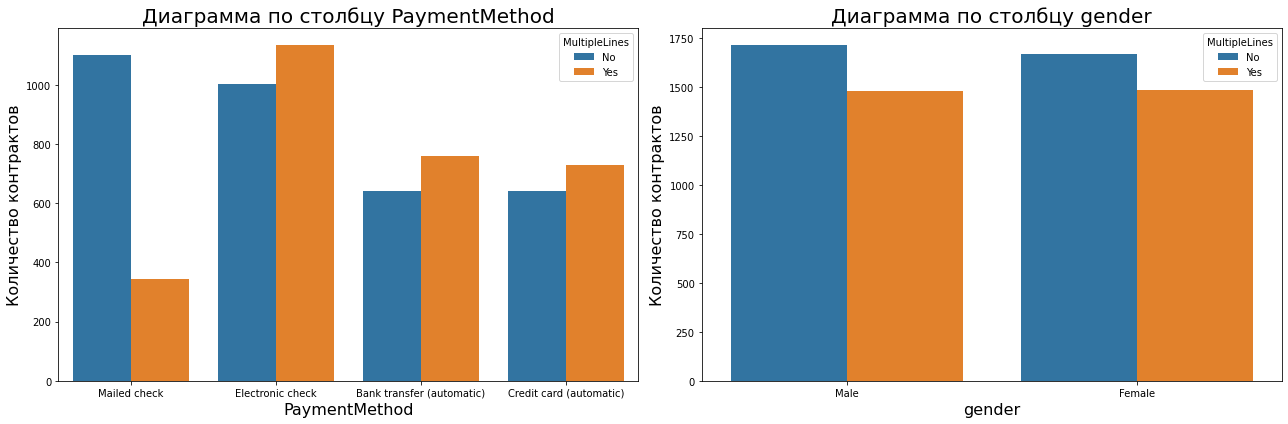

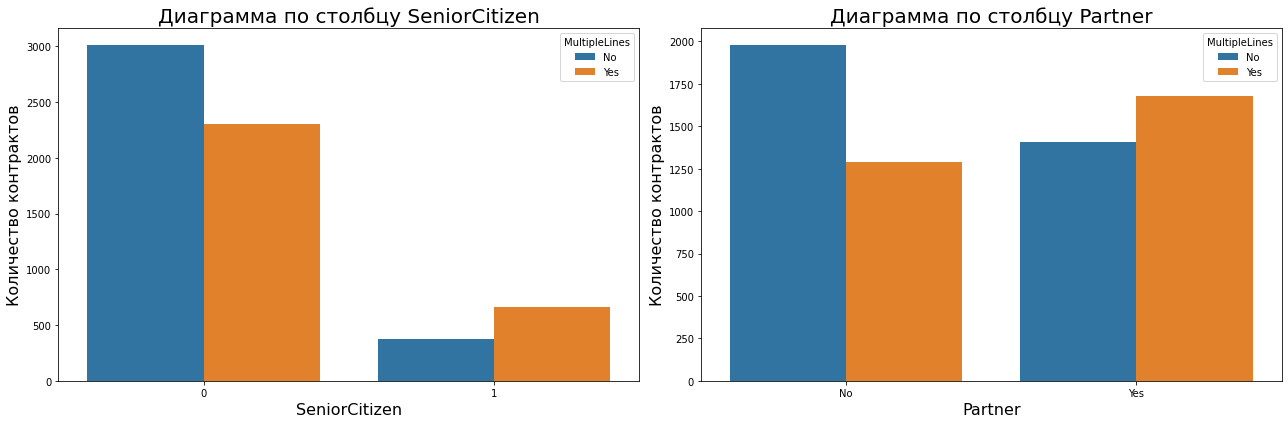

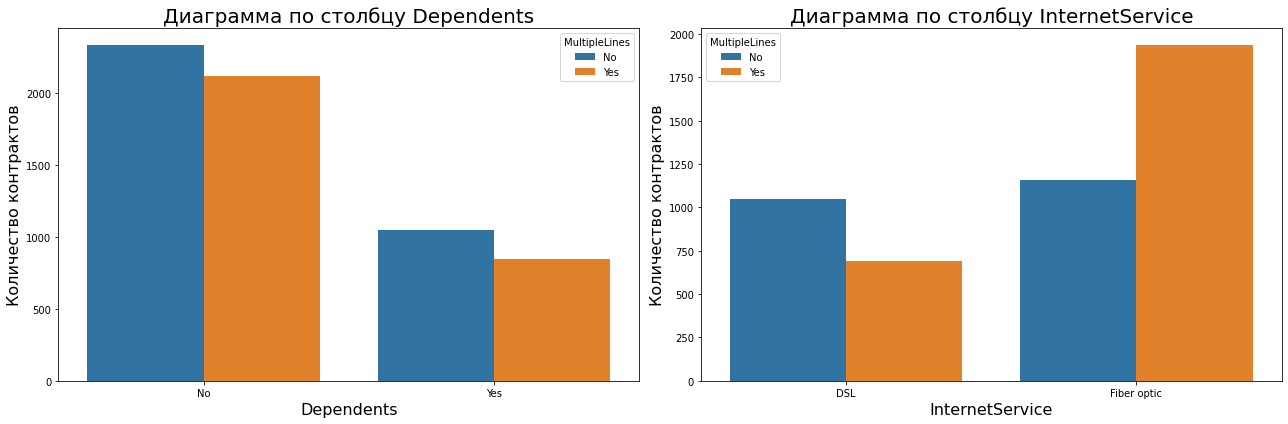

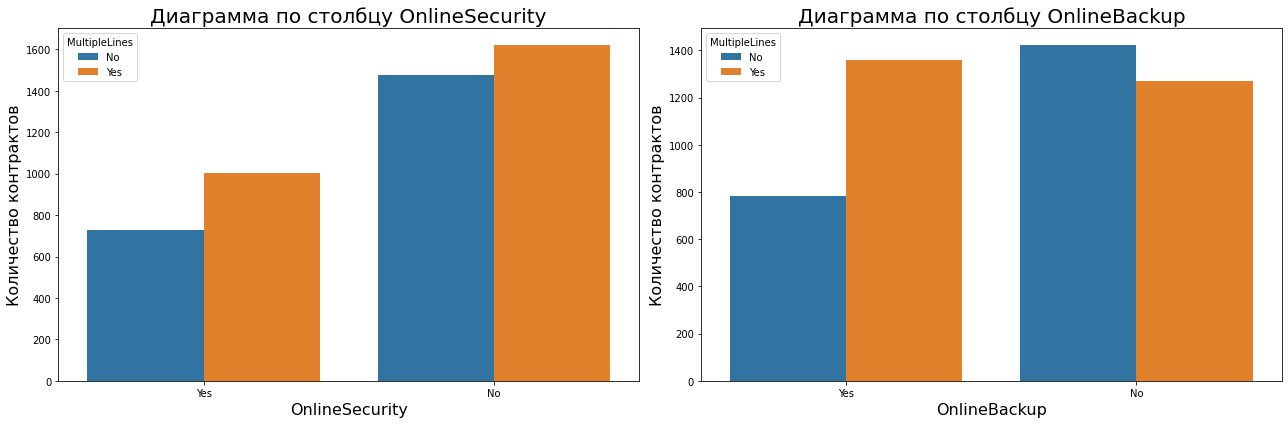

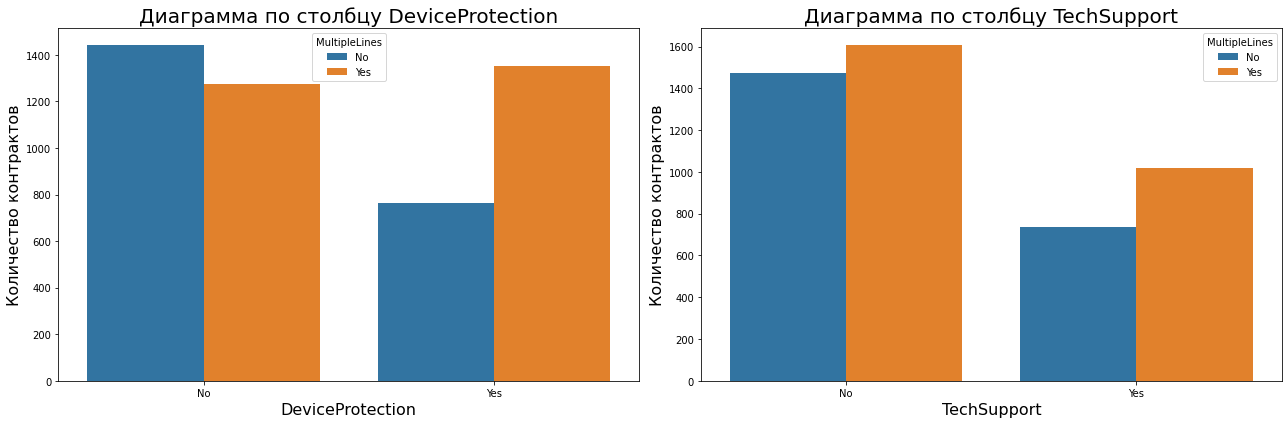

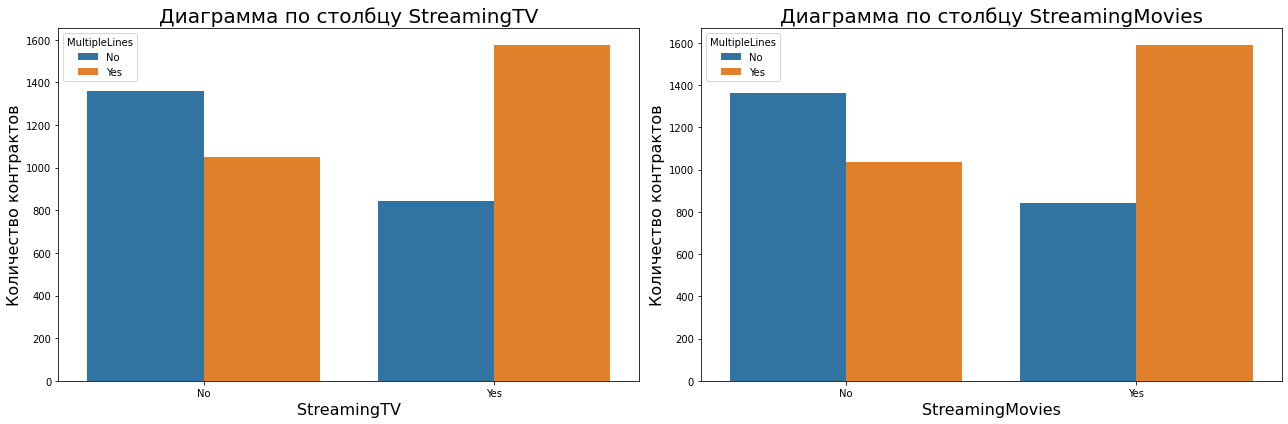

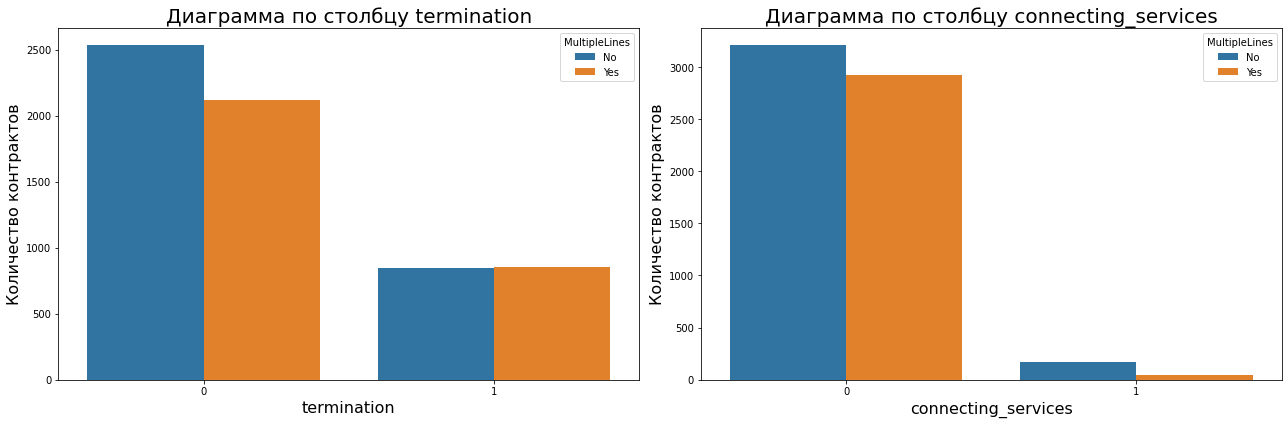

In [90]:
for i in range(0, len(cat_cols), 2):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    for j, col in enumerate(cat_cols[i:i+2]):
        sns.countplot(data=df, x=col, hue="MultipleLines", ax=axs[j])
        axs[j].set_xlabel(col, fontsize=16)
        axs[j].set_ylabel('Количество контрактов', fontsize=16)
        axs[j].set_title(f'Диаграмма по столбцу {col}', fontsize=20)
    plt.tight_layout()
    plt.show()

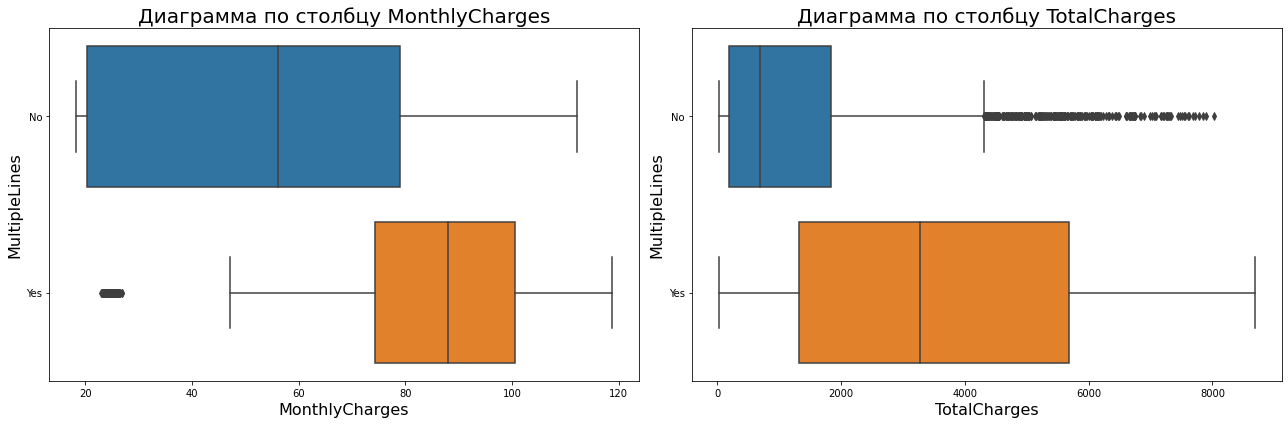

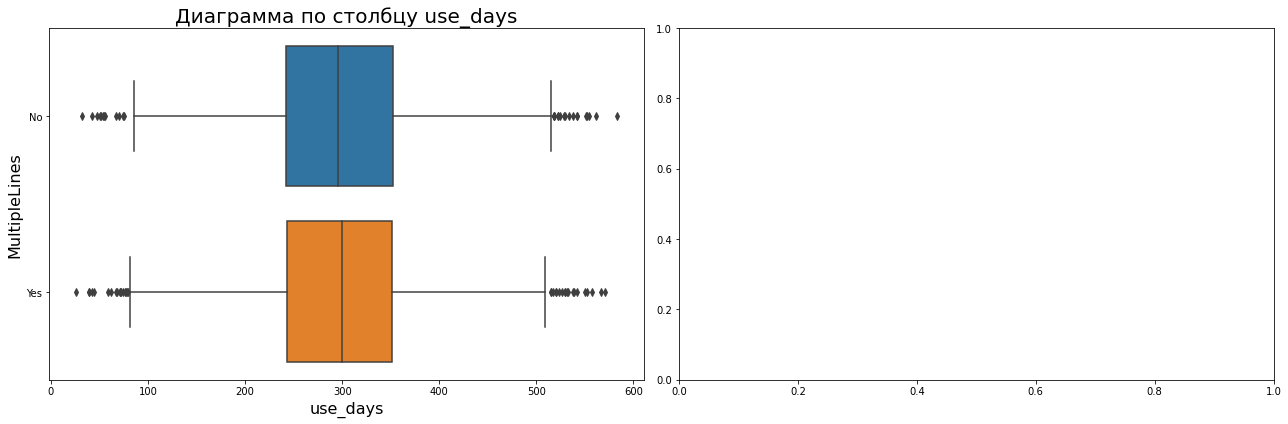

In [91]:
for i in range(0, len(num_cols), 2):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    for j, col in enumerate(num_cols[i:i+2]):
        sns.boxplot(data=df, x=col, y="MultipleLines", ax=axs[j])
        axs[j].set_xlabel(col, fontsize=16)
        axs[j].set_ylabel('MultipleLines', fontsize=16)
        axs[j].set_title(f'Диаграмма по столбцу {col}', fontsize=20)
    plt.tight_layout()
    plt.show()

На основе представленных диаграмм невозможно сделать каких-либо уверенных утверждений по заполнению пропусков столбца *MultipleLines*. Так как количество пропусков по данному столбцу составляет более 600, то мы заполним его значением "no_info".

#### Анализ соотношений ушедших и оставшихся клиентов для каждого признака

Анализ соотношения ушедших и оставшихся клиентов для каждого признака будем выполнять графическим методом путём вывода на экран соответствующих диаграмм. Первоначально выведем диаграммы для категоральных признаков.

In [92]:
cat_cols = df.drop(columns=['customerID', 
                            'termination',
                            'BeginDate', 
                            'EndDate',
                            'MonthlyCharges', 
                            'TotalCharges', 
                            'use_days']
                  ).columns.tolist()

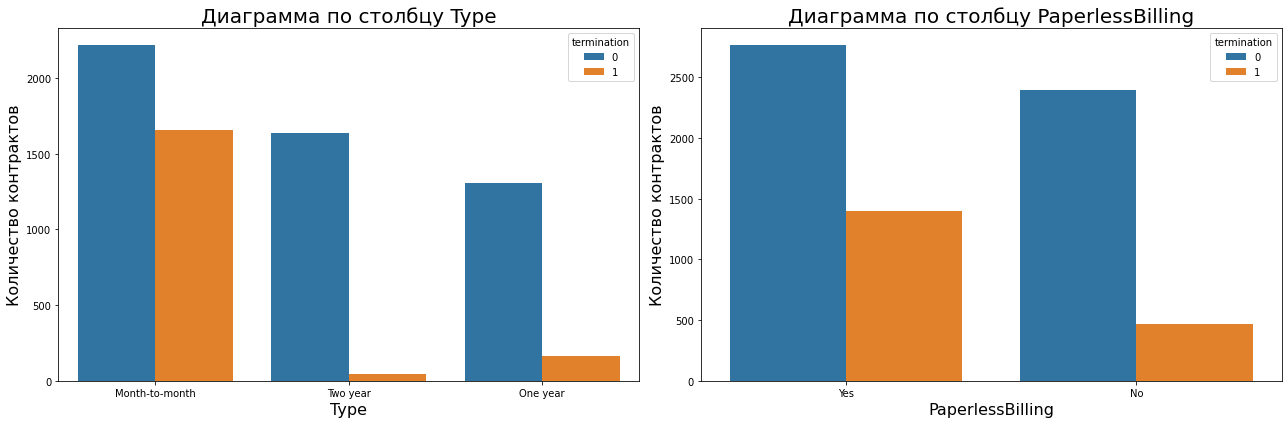

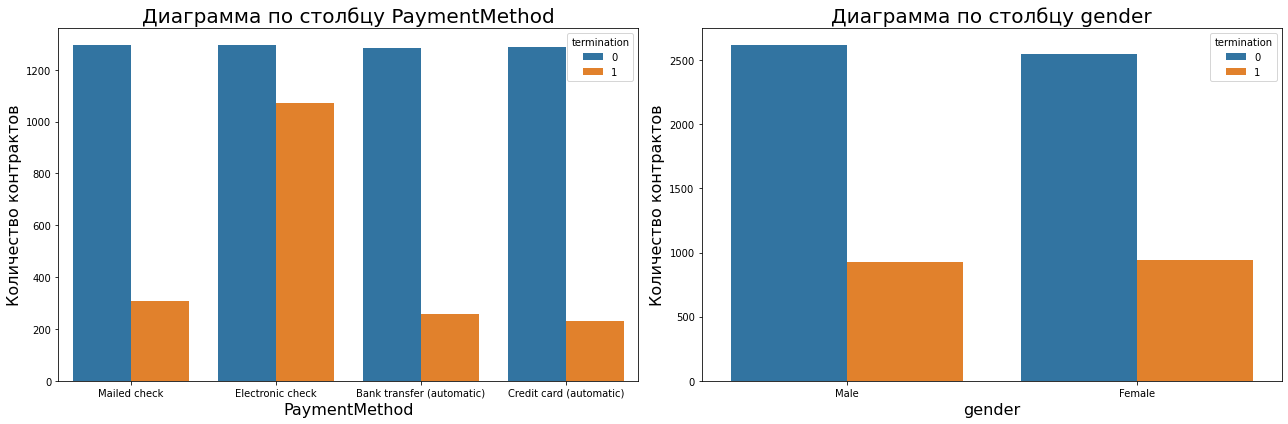

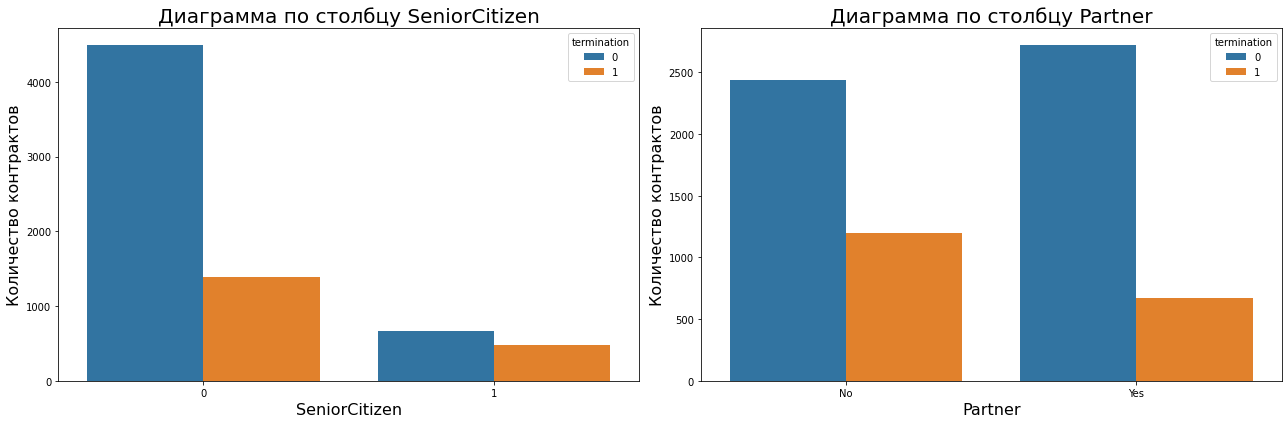

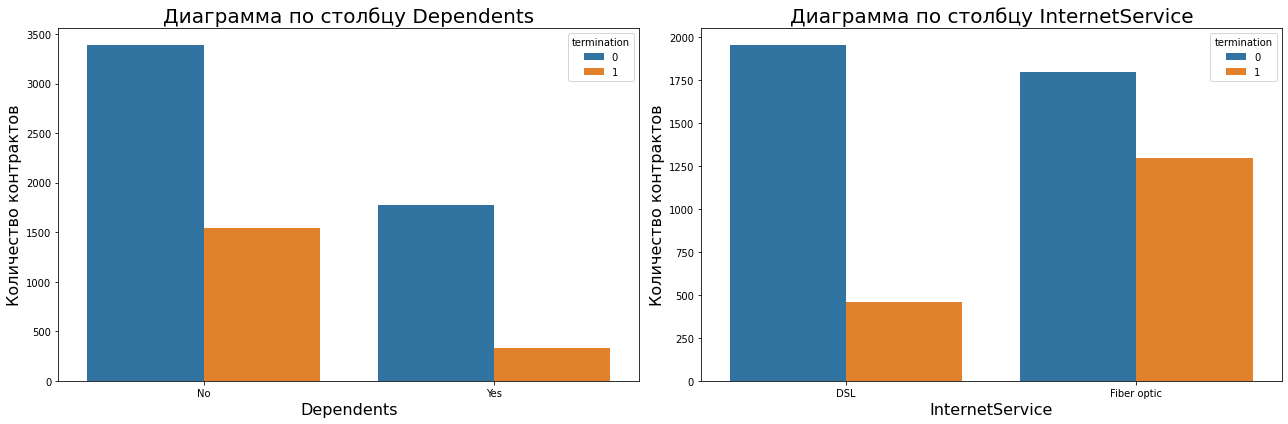

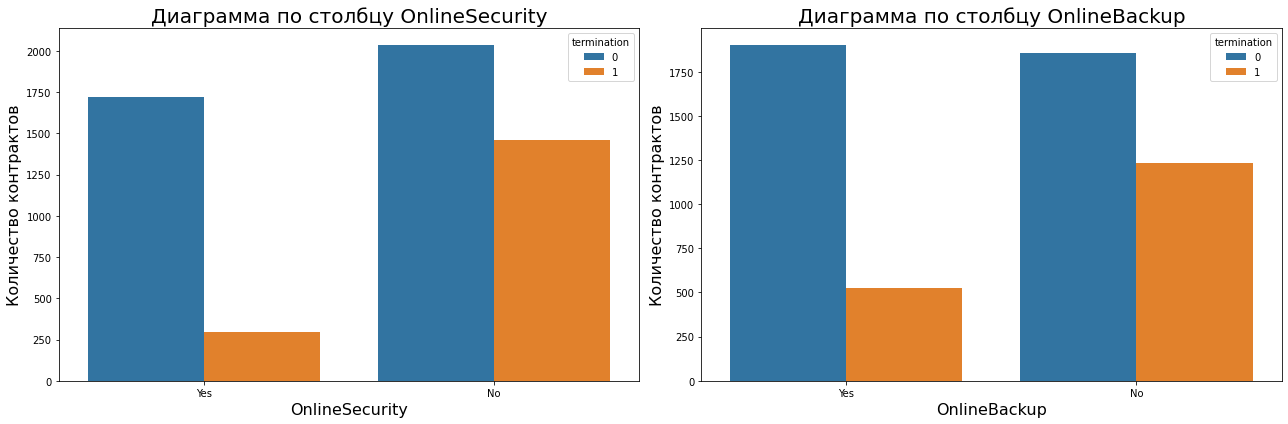

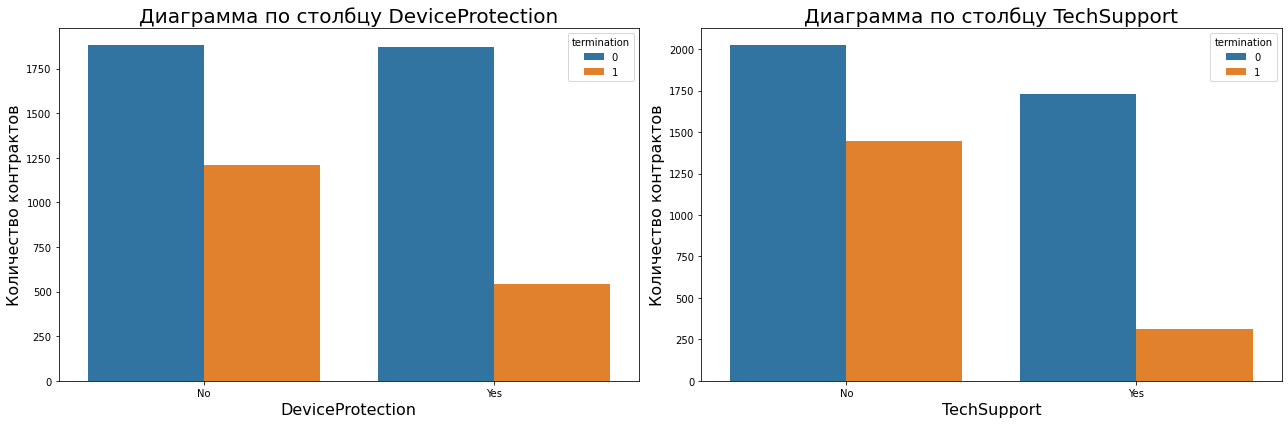

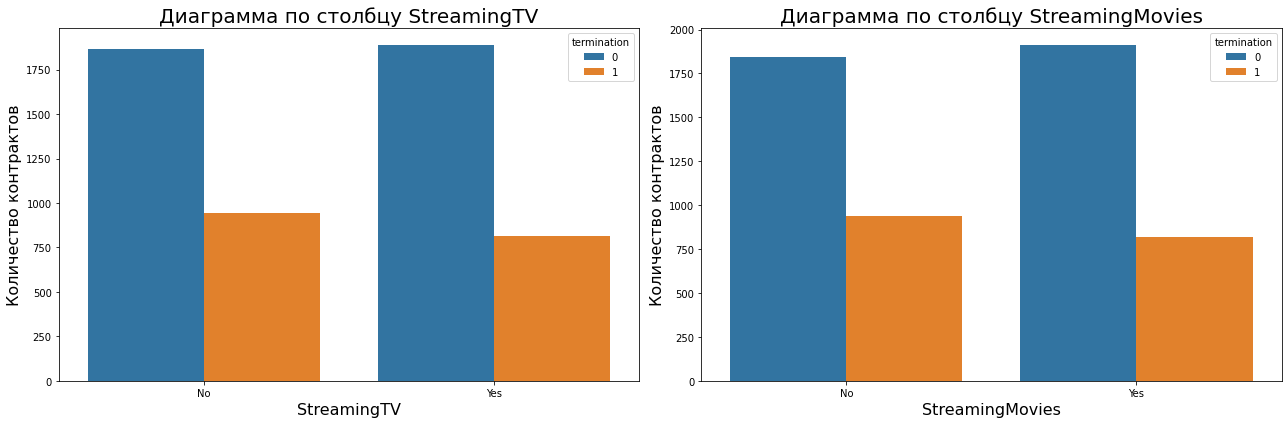

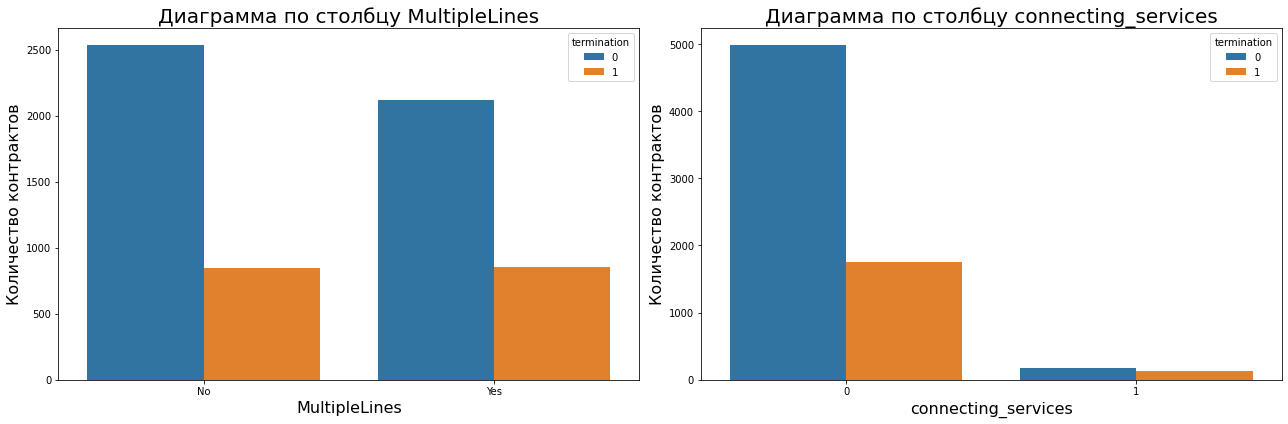

In [93]:
for i in range(0, len(cat_cols), 2):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    for j, col in enumerate(cat_cols[i:i+2]):
        sns.countplot(data=df, x=col, hue="termination", ax=axs[j])
        axs[j].set_xlabel(col, fontsize=16)
        axs[j].set_ylabel('Количество контрактов', fontsize=16)
        axs[j].set_title(f'Диаграмма по столбцу {col}', fontsize=20)
    plt.tight_layout()
    plt.show()

Из полученных диаграмм мы можем сделать вывод, что потенциальная угроза ухода клиента выше если он:
1. Выполняет оплату услуги ежемесячно;
2. Использует электронный счёт и пользуется электронным чеком;
3. Является пенсионером;
4. Не имеет супруга/супруги;
5. Подключил услугу по оптической системе передачи данных, блокировку опасных сайтов, облачное хранилище файлов для резервного копирования данных или многоканальную линию связи;
6. Не подключал антивирус или выделенную линию техподдержки.

Так же приведём грачическую оценку по числовым столбцам.

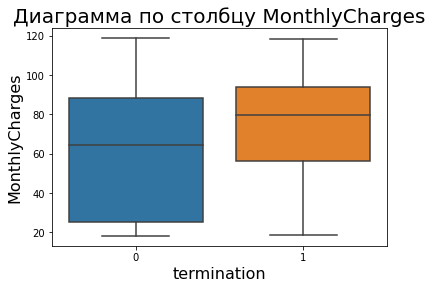

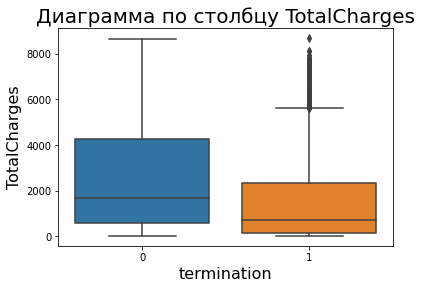

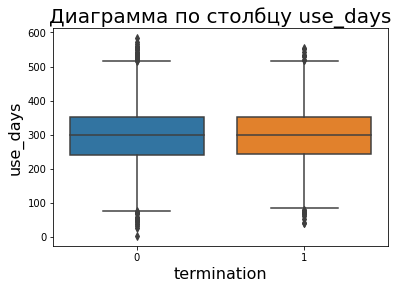

In [94]:
for col in num_cols:
    sns.boxplot(data=df, x="termination", y=col)
    plt.xlabel('termination', fontsize=16)
    plt.ylabel(col, fontsize=16)
    plt.title(f'Диаграмма по столбцу {col}', fontsize=20)
    plt.show()

Из полученных диаграмм мы можем сделать дополнительный вывод о том, что потенциальная угроза ухода клиента выше если его ежемесячные расходы больше среднего значения, а годовые наоборот - меньше.

#### **Выводы**

По результатам выполнения пункта установлено, что потенциальная угроза ухода клиента выше если он:
1. Выполняет оплату услуги ежемесячно;
2. Использует электронный счёт и пользуется электронным чеком;
3. Является пенсионером;
4. Не имеет супруга/супруги;
5. Подключил услугу по оптической системе передачи данных, блокировку опасных сайтов, облачное хранилище файлов для резервного копирования данных или многоканальную линию связи;
6. Не подключал антивирус или выделенную линию техподдержки;
7. Осуществляет среднемесячный платёж больше среднего, а годовой наоборот - меньше.

### Оценка Фк-корреляции признаков

Дополнительно оценим корреляцию признаков между собой по коэффициенту Фк. Результат визуализируем на тепловой карте.

In [95]:
columns = ['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
           'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'termination', 'use_days']

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'termination', 'use_days']


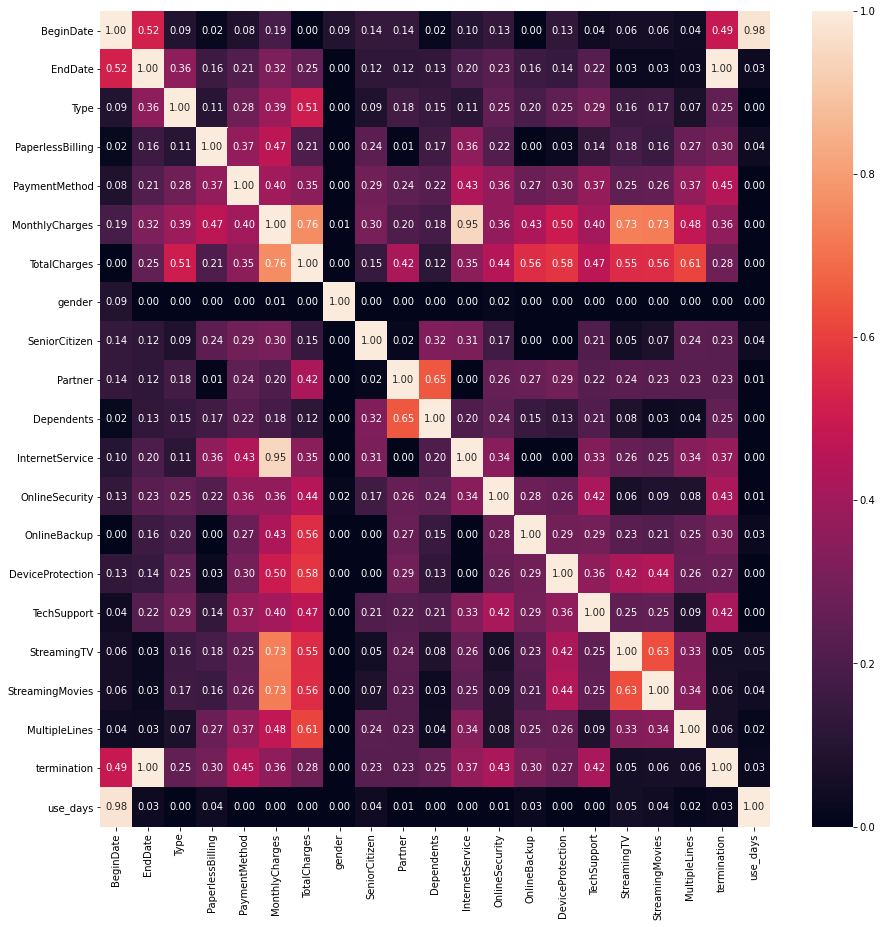

In [96]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(df[columns].phik_matrix(), annot=True, fmt=".2f")

На основе полученных данных мы видим, что имеются следующие основные особенности корреляций:
1. Имеется коррекляция между признаками "use_days", "BeginDate", "termination" и "EndDate". Данная корреляция связана с тем, что столбцы "use_days" и "termination" созданы на основе столбцов "BeginDate" и "EndDate". Таким образом, что бы избежать утечки мы оставим только обучающий признак "use_days" и целевой "termination".
2. Суммы ежемесечного и годовых платежей хорошо коррелируют с набором услуг, которые подключил клиент. При такой корреляции утечки по целевому признаку не наблюдаются.

### **Выводы по исследовательскому анализу данных**

По результатам исследовательского анализа данных :
1. Выполнено объединение датафреймов по столбцу "customerID" в один с наименованем *df*. Аномальные значения в датафрейме отсутствуют.
2. Предварительно, в датафрейме созданы два дополнительных столбца:
    * Столбец с целевым признаком termination;
    * Дополнительный столбец признак use_days с количеством дней предоставления услуг пользователю.
3. Строки, в которые дата заключения договора совпадала с датой актуализации таблицы были исключены, так как по ним невозможно сделать оценку ухода клиента.
4. Пропуска в датафрейме имеются только в столбцах с информацией о подключении клиентом дополнительных услуг. Эти пропуска будут заполнены категорией "no_info"
5. Предварительно выполнена оценка потенциальной опасности ухода клиента. По результатам этой оценки установлено, что потенциальная угроза ухода клиента выше если он:
    * Выполняет оплату услуги ежемесячно;
    * Использует электронный счёт и пользуется электронным чеком;
    * Является пенсионером;
    * Не имеет супруга/супруги;
    * Подключил услугу по оптической системе передачи данных, блокировку опасных сайтов, облачное хранилище файлов для резервного копирования данных или многоканальную линию связи;
    * Не подключал антивирус или выделенную линию техподдержки;
    * Осуществляет среднемесячный платёж больше среднего, а годовой наоборот - меньше.
6. По результатам оценки Фк корреляции определены следующие основные особенности корреляций:
    * Имеется коррекляция между признаками "use_days", "BeginDate", "termination" и "EndDate". Данная корреляция связана с тем, что столбцы "use_days" и "termination" созданы на основе столбцов "BeginDate" и "EndDate". Таким образом, что бы избежать утечки мы оставим только обучающий признак "use_days" и целевой "termination".
    * Суммы ежемесечного и годовых платежей хорошо коррелируют с набором услуг, которые подключил клиент. При такой корреляции утечки по целевому признаку не наблюдаются.

## Подготовка данных для обучения

Первоначально выполним заполнение пропусков значениями "no_info", как было определено в пункте 2.3.1.

In [97]:
df.fillna('no_info', inplace=True)

Далее выполним деление данных на тренировочные и тестовые и перезапишем индексы.

In [98]:
features = df.drop(columns=['customerID', 'BeginDate', 'EndDate', 'termination', 'connecting_services'])
target = df['termination']

In [99]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25,
                                                                              random_state=RANDOM_STATE, stratify=target)

In [100]:
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

Мы получили две выборки. Тренировочную для обучения и выполнения кросс-валидации модели, а также тестовую, на которой будем проверять работу наилучшей модели. В соответствии с условиями задачи нам потребуется разработать три типа моделей:
1. Модель на основе случайного леса;
2. Модель на основе градиентного бустинга;
3. Модель нейронной сети.

Учитывая, что для нейронной сети необходимо выполнять подбор количества эпох для неё необходимо будет дополнительно создать валидационные данные. Таким образом, нам потребуется подготовка данных для трёх моделей:
1. Для кросс-валидации - тренировочная;
2. Для подбора количества эпох нейронной сети - тренировочная и валидационная.

Таким образом, для каждого типа модели нам необходимо выполнить определённую подготовку данных.

### Формирование данных под модель градиентного бустинга

Модель градиентного бустинга мы будем создавать с помощью инструмента CatBoost с кросс-валидацей, поэтому нам не потребуется преобразование (масштабирование и кодирование) входных признаков для модели. Перезапишем их специально для работы с моделью catboost.

In [101]:
features_train_cb = features_train.copy()
features_test_cb = features_test.copy()

Датафреймы с целевыми признаками, при этом не изменятся.

### Формирование данных под модель нейронной сети.

Первоначально выделим из тренировочных данных валидационную выборку и перезапишем индексы.

In [102]:
features_train_net, features_valid_net, target_train_net, target_valid_net = train_test_split(features_train, 
                                                                                              target_train, 
                                                                                              test_size = 0.2,
                                                                                              random_state=RANDOM_STATE,
                                                                                              stratify=target_train
                                                                                             )

In [103]:
features_train_net.reset_index(drop=True, inplace=True)
features_valid_net.reset_index(drop=True, inplace=True)
target_train_net.reset_index(drop=True, inplace=True)
target_valid_net.reset_index(drop=True, inplace=True)

Отмасштабируем данные.

In [104]:
cols_scaler = ['MonthlyCharges', 'TotalCharges', 'use_days']

In [105]:
scaler = StandardScaler()

features_train_net[cols_scaler] = scaler.fit_transform(features_train_net[cols_scaler])
features_valid_net[cols_scaler] = scaler.transform(features_valid_net[cols_scaler])

/tmp/ipykernel_48/3602689707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_net[cols_scaler] = scaler.fit_transform(features_train_net[cols_scaler])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/3602689707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Выполним кодировку категориальных признаков.

In [106]:
cat_cols = features_train_net.drop(columns=cols_scaler).columns.tolist()

In [107]:
encoder = OneHotEncoder(sparse=False, drop='first')

In [108]:
encoded_cols_train_net = encoder.fit_transform(features_train_net[cat_cols])
encoded_cols_train_net = pd.DataFrame(encoded_cols_train_net, columns=encoder.get_feature_names(cat_cols))
features_train_net = pd.concat([features_train_net, encoded_cols_train_net], axis=1).drop(columns=cat_cols)

In [109]:
encoded_cols_valid_net = encoder.transform(features_valid_net[cat_cols])
encoded_cols_valid_net = pd.DataFrame(encoded_cols_valid_net, columns=encoder.get_feature_names(cat_cols))
features_valid_net = pd.concat([features_valid_net, encoded_cols_valid_net], axis=1).drop(columns=cat_cols)

### Подготовка данных для кросс-валидации модели случайного леса и тестирования моделей нейронной сети и случайного леса

#### Масштабирование числовых признаков

Для удобства масштабирования создадим список cols_scaler с названиями колонок, которые требуется отмасштабировать.

In [110]:
cols_scaler = ['MonthlyCharges', 'TotalCharges', 'use_days']

In [111]:
scaler = StandardScaler()

features_train[cols_scaler] = scaler.fit_transform(features_train[cols_scaler])
features_test[cols_scaler] = scaler.transform(features_test[cols_scaler])

/tmp/ipykernel_48/1261019747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[cols_scaler] = scaler.fit_transform(features_train[cols_scaler])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/1261019747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Для проверки выведем первые 10 строк отмасштабированных столбцов тестовой выборки.

In [112]:
features_test[cols_scaler].head(10)

,MonthlyCharges,TotalCharges,use_days
0,0.489296,-0.695404,1.257035
1,-0.534608,-0.864644,1.365332
2,-0.325512,-0.552689,0.077802
3,0.471042,0.123252,-0.066594
4,1.621067,2.592386,-0.126759
5,0.812896,0.836761,1.136705
6,0.150761,-0.864047,0.390659
7,1.305764,2.210863,-0.054561
8,1.003737,-0.273134,-1.041267
9,1.601153,2.460868,-1.606818


Масштабирование выполнено успешно.

#### Кодирование признаков 

Так как во всех признаках количество категорий не велико, мы применим метод горячего кодирования.

In [113]:
cat_cols = features_train.drop(columns=cols_scaler).columns.tolist()

In [114]:
encoder = OneHotEncoder(sparse=False, drop='first')

In [115]:
encoded_cols_train = encoder.fit_transform(features_train[cat_cols])
encoded_cols_train = pd.DataFrame(encoded_cols_train, columns=encoder.get_feature_names(cat_cols))
features_train = pd.concat([features_train, encoded_cols_train], axis=1).drop(columns=cat_cols)

In [116]:
encoded_cols_test = encoder.transform(features_test[cat_cols])
encoded_cols_test = pd.DataFrame(encoded_cols_test, columns=encoder.get_feature_names(cat_cols))
features_test = pd.concat([features_test, encoded_cols_test], axis=1).drop(columns=cat_cols)

Для проекрки результата выведем на экран размерности датафреймов и первые пять строк тренировочной выборки.

In [117]:
print(features_train.shape, features_test.shape)
features_train.head()

(5274, 29) (1758, 29)


,MonthlyCharges,TotalCharges,use_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,DeviceProtection_Yes,DeviceProtection_no_info,TechSupport_Yes,TechSupport_no_info,StreamingTV_Yes,StreamingTV_no_info,StreamingMovies_Yes,StreamingMovies_no_info,MultipleLines_Yes,MultipleLines_no_info
0,-0.688940,0.315328,-0.343353,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.044554,0.398082,-1.101432,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.369813,0.991447,-0.800607,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.108285,2.084027,0.017637,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.710008,-0.620403,-0.608079,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Кодирование выполнено успешно. Приступим к созданию модели.

### **Выводы**

По результатам подготовки данных выполнено:
1. Все пропуска в столбцах датафрейма заполнены значениями "no_info"
2. Датафрейм разделён на тренировочную и тестовую выборки: features_train, features_test, target_train, target_test. 
3. Для работы с моделью градиентного бустинга созданы копии с тренировочными и тестовыми признаками features_train_cb и features_test_cb, для которых не выполнено масштабирование и кодирование признаков.
4. Для обеспечения создания нейронной сети с подбором количества эпох дополнительно созданы выборки с тренировочными и валидационными данными features_train_net, features_valid_net, target_train_net, target_valid_net. Признаки в данных выборках отмасштабированны и закодированы.
5. Для создания модели случайного леса, а также тестирования (при необходимости) модели нейронной сети признаки в features_train и features_test также отмасштабированны и закодированы.

## Создание и обучение моделей.

По условиям задачи мы создадим и оценим следующие модели:
1. модель случайного леса;
2. модель градиентного бустинга на основе catboost;
3. модель нейронной сети.

Оценку работы модели будем выполнять с записью результата в сводный датафрейм *df_pivot*.

In [118]:
df_pivot = pd.DataFrame(columns=['model', 'ROC-AUC'])

### Модель случайного леса

Инициируем модель и создадим сетку перебираемых гиперпараметров.

In [119]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

In [120]:
param_grid_rf = {"max_depth"         : list(range(1,16)),
                 "n_estimators"      : list(range(1,200)),
                 "min_samples_split" : list(range(2,5)),
                 "min_samples_leaf"  : list(range(1,4))
                 }

Выполним подбор гиперпараметров с использованием инструмента RandomizedSearchCV.

***Примечание:*** Первоначально, количество итераций при поиске составляло 1000. После проверки оно было сокращено до 300 (для сокращения времени ожидания кода), так как при дальнейших итерациях модель не улучшалась.

In [121]:
%%time
rs_rf = RandomizedSearchCV(model_rf, param_grid_rf, n_iter=300, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE)
rs_rf.fit(features_train, target_train)

CPU times: user 8min 2s, sys: 2.15 s, total: 8min 4s
Wall time: 8min 7s


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=200224),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   random_state=200224, scoring='roc_auc')

Для оценки результата выведем на экран наилучшее значение метрики ROC-AUC и перезапишем модель.

In [122]:
rs_rf.best_score_

0.8429232116536166

In [123]:
model_rf = rs_rf.best_estimator_ 

Мы получили, что значение метрики AUC составляет 0,842. Запишем результат в сводную таблицу

In [124]:
k=0
df_pivot.loc[k,'model'] = 'model_rf'
df_pivot.loc[k,'ROC-AUC'] = rs_rf.best_score_
k +=1

### Модель градиентного бустинга

Первоначально, создадим список категориальных столбцов и пулы данных.

In [125]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 
                'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [126]:
train_data = Pool(data=features_train_cb,
                  label=target_train,
                  cat_features=cat_features
                 )

In [127]:
test_data = Pool(data=features_test_cb, 
                 cat_features=cat_features
                )

Далее инициируем модель, создадим сетку перебора гиперпараметров и "прогоним" модель по этой сетке.

In [128]:
model_cb = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=200, random_seed=RANDOM_STATE)

In [129]:
grid = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
        'depth': [4, 5, 6, 7, 8]
       }

In [130]:
%%time
grid_search_result = model_cb.grid_search(grid,
                                          X=train_data,
                                          cv=5,
                                          plot=True
                                         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7760720	best: 0.7760720 (0)	total: 58.5ms	remaining: 58.5s
200:	test: 0.8282787	best: 0.8282787 (200)	total: 1.63s	remaining: 6.49s
400:	test: 0.8331355	best: 0.8331500 (397)	total: 3.23s	remaining: 4.82s
600:	test: 0.8346507	best: 0.8347182 (594)	total: 4.85s	remaining: 3.22s
800:	test: 0.8359246	best: 0.8359584 (794)	total: 6.39s	remaining: 1.59s
999:	test: 0.8366967	best: 0.8367015 (998)	total: 8.1s	remaining: 0us

bestTest = 0.8367015065
bestIteration = 998

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8367015	best: 0.8367015 (0)	total: 8.77s	remaining: 3m 30s
0:	test: 0.7760720	best: 0.7760720 (0)	total: 15.9ms	remaining: 15.8s
200:	test: 0.8337483	best: 0.8337773 (198)	total: 1.52s	remaining: 6.05s
400:	test: 0.8364699	best: 0.8365085 (399)	total: 3.09s	remaining: 4.62s
600:	test: 0.8372661	best: 0.8379079 (518)	total: 4.79s	remaining: 3.18s
800:	test: 0.8375701	best: 0.

Из полученных результатов мы видим, что с увеличением количества деревьев целевая метрика ROC-AUC снижается. При этом нельзя говорить о том, что увеличение параметра learning_rate приводит к улучшению целевой метрики. Посмотрим на какой итерации мы получили наилучшее значение целевой метрики.

In [131]:
pd.DataFrame(grid_search_result['cv_results']).sort_values(by='test-AUC-mean',ascending=False).head(10)

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
232,232,0.845922,0.020684,0.416586,0.022955,0.385603,0.006519
231,231,0.845873,0.020645,0.416630,0.022895,0.385729,0.006594
248,248,0.845866,0.020699,0.416813,0.023094,0.383364,0.006597
238,238,0.845865,0.020598,0.416688,0.022905,0.384826,0.006643
233,233,0.845863,0.020782,0.416624,0.023012,0.385474,0.006535
249,249,0.845854,0.020685,0.416832,0.023097,0.383158,0.006494
239,239,0.845852,0.020593,0.416686,0.022900,0.384741,0.006660
247,247,0.845838,0.020694,0.416824,0.023040,0.383557,0.006582
237,237,0.845837,0.020639,0.416690,0.022919,0.384891,0.006594
246,246,0.845832,0.020703,0.416805,0.023038,0.383678,0.006549


Мы видим, что наилучшее среднее значение целевой метрики для модели получается на малых значениях итерраций. Таким образом дополнительно поработаем с параметром learning_rate и попробуем подобрать его при кросс-валидации модели. 
Для этого создадим словарь параметров и выполним кросс-валидацию модели.

***Примечание:*** Выполнение подбора параметра learning_rate выполнялось путём многократной крос-валидации с целью обеспечения обучения модели на итеррации, близкой к 1000.

In [132]:
params = {'depth'        : 4,
          'eval_metric'  : 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.023,
          'random_seed'  : RANDOM_STATE,
          'verbose'      :200}

In [133]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    stratified=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	test: 0.7262082	best: 0.7262082 (0)	total: 9.98ms	remaining: 9.97s
200:	test: 0.8178900	best: 0.8180737 (195)	total: 1.76s	remaining: 7.01s
400:	test: 0.8193640	best: 0.8195201 (393)	total: 3.54s	remaining: 5.29s
600:	test: 0.8207875	best: 0.8208885 (597)	total: 5.53s	remaining: 3.67s
800:	test: 0.8210033	best: 0.8211089 (793)	total: 7.51s	remaining: 1.86s
999:	test: 0.8210401	best: 0.8212743 (874)	total: 9.44s	remaining: 0us

bestTest = 0.8212742509
bestIteration = 874

Training on fold [1/5]
0:	test: 0.7388061	best: 0.7388061 (0)	total: 9.56ms	remaining: 9.56s
200:	test: 0.8390724	best: 0.8390724 (200)	total: 1.97s	remaining: 7.83s
400:	test: 0.8386638	best: 0.8393204 (293)	total: 3.7s	remaining: 5.52s
600:	test: 0.8370841	best: 0.8393204 (293)	total: 5.55s	remaining: 3.68s
800:	test: 0.8365423	best: 0.8393204 (293)	total: 7.57s	remaining: 1.88s
999:	test: 0.8357387	best: 0.8393204 (293)	total: 9.66s	remaining: 0us

bestTest = 0.8393203995
bestIteration = 29

Перезапишем нашу модель и обучим её на полном наборе данных. Результат кросс-валидации внесём в нашу сводную таблицу.

In [134]:
model_cb = CatBoostClassifier(**params)
model_cb.fit(train_data)

0:	total: 15.6ms	remaining: 15.6s
200:	total: 1.77s	remaining: 7.05s
400:	total: 3.59s	remaining: 5.37s
600:	total: 5.57s	remaining: 3.7s
800:	total: 7.39s	remaining: 1.83s
999:	total: 9.23s	remaining: 0us


In [135]:
df_pivot.loc[k,'model'] = 'model_cb'
df_pivot.loc[k,'ROC-AUC'] = cv_data['test-AUC-mean'].max()
k +=1

### Модель нейронной сети

Перед началом построения базовой нейронной сети напишем ряд функций, которые упростят процесс создания модели.

#### Создание функций

##### Функции отображения графиков

Создадим функцию graph_auc_score отображения графика зависимости показателя качества ROC-AUC от номера эпохи (итеррации), которая потребуется для визуальной оценки процесса обучения модели. На входе функция будет принимать сводную таблицу и границы шкалы ROC-AUC.

In [136]:
def graph_auc_score(data, y_min, y_max):
    fig, ax = plt.subplots(figsize=(20, 10))
    for col in data.columns:
        if col != "num_epoch":
            ax.plot(data['num_epoch'], data[col], label=col)
    ax.legend()
    plt.title('График зависимости ROC-AUC от номера эпохи для различных моделей', fontsize=20)
    plt.xlabel('Номер эпохи', fontsize=16)
    plt.ylabel('ROC-AUC', fontsize=16)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    plt.show()

##### Функции для создания нейронной сети

Создадим функцию model_training обучения сети. Отметим, что обучение будет выполняться с L2-регуляризацией.

In [137]:
def model_training(train_x, train_y):
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()
    
    l2_lambda = 0.0005
    l2_norm = sum(p.pow(2.0).sum() for p in net.parameters())
    
    loss_value = torch.sqrt(loss(preds, train_y)) + l2_lambda * l2_norm
    loss_value.backward()

    optimizer.step()

Создадим функцию model_validating, которая будет определять предсказания сети для валидационных данных и расчитывать показатель качества ROC-AUC.

In [138]:
def model_validating(epoch):
    net.eval()
    valid_preds = net.forward(X_valid)
    predicts = [item for sublist in valid_preds.tolist() for item in sublist]
    ROC_AUC = roc_auc_score(target_valid_net, predicts)
    return valid_preds, ROC_AUC

Создадим функцию init_weights, которая будет инициализировать веса методом Ксавье.

In [139]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight) 

#### Построение нейронной сети

Построение нейроной сети будем выполнять с подбором количества слоёв и количеством нейронов в слоях. Таким образом, сперва мы создадим сеть с двумя скрытыми слоями, а затем с тремя и для каждого случая будем подбирать кол-во нейронов.

Первоначально создадим необходимые для работы тензоры X_train, X_valid, y_train и y_valid и запишем в переменные in_neurons и out_neurons количество нейронов во входном и выходном слоях.

In [140]:
X_train = torch.FloatTensor(features_train_net.values)
X_valid = torch.FloatTensor(features_valid_net.values)
y_train = torch.FloatTensor(target_train_net.values)
y_valid = torch.FloatTensor(target_valid_net.values)

In [141]:
in_neurons = X_train.shape[1]
out_neurons = 1

Так же инициируем датафрейм, в который будем записывать результаты расчётов. Первым столбцом, в сводную таблицу запишем номера эпох с шагом 10. Далее, по мере расчётов, будем добавлять столбцы с результатами ROC-AUC на каждом шаге эпох. В названия столбцов будем закладывать значения перебираемых параметров модели

In [142]:
df_model_result = pd.DataFrame(data = {'num_epoch':list(range(0, 200, 10))})

##### Нейроная сеть с двумя скрытыми слоями.

Выполним обучение модели с двумя скрытыми слоями и разным количеством нейронов в слоях. В процессе обучение будем оценивать работу модели на валидаионных данных.

In [143]:
%%time

best_auc = 10

for hidden_neurons_1 in list(range(10, 30)):
    for hidden_neurons_2 in list(range(1, 15)):
        torch.manual_seed(RANDOM_STATE)
        class base_model(nn.Module):
            def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons):
                super(base_model, self).__init__()
                self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
                self.ac1 = nn.ReLU()
                self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
                self.ac2 = nn.ReLU()
                self.fc3 = nn.Linear(hidden_neurons_2, out_neurons)
                self.ac3 = nn.Sigmoid()

            def forward(self, x):
                x = self.fc1(x)
                x = self.ac1(x)
                x = self.fc2(x)
                x = self.ac2(x)
                x = self.fc3(x)
                x = self.ac3(x)
                return x
            
        net = base_model(in_neurons, hidden_neurons_1, hidden_neurons_2, out_neurons)
        
        net.apply(init_weights)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
        loss = nn.BCELoss()

        num_epochs = 200
        
        i = 0
        
        for epoch in range(num_epochs):
            model_training(X_train, y_train)
            if epoch % 10 == 0:
                valid_preds, auc = model_validating(epoch)

                column_name = "hid_neur_1=" + str(hidden_neurons_1) + "/hid_neur_2=" + str(hidden_neurons_2)
                df_model_result.loc[i,column_name] = auc
                i = i + 1
                if auc > best_auc:
                    best_auc = best_auc

CPU times: user 13min 8s, sys: 15.8 s, total: 13min 24s
Wall time: 13min 31s


Посмотрим результаты и определим налучшую модель. Для этого выведем на экран график обучения пяти моделей с наивысшими значениями ROC-AUC.

In [144]:
cols = df_model_result.max().sort_values(ascending=False).index[0:6]

In [145]:
df_model_result.max().sort_values(ascending=False).head()

num_epoch                      190.000000
hid_neur_1=20/hid_neur_2=9       0.839641
hid_neur_1=21/hid_neur_2=3       0.838820
hid_neur_1=11/hid_neur_2=4       0.838581
hid_neur_1=18/hid_neur_2=11      0.838147
dtype: float64

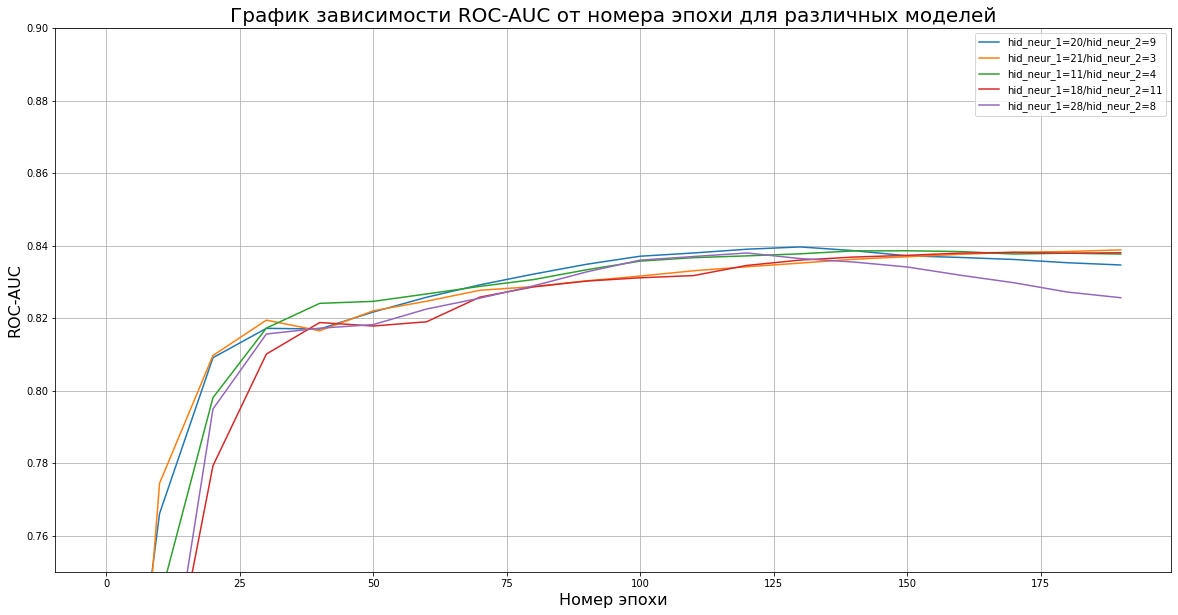

In [146]:
graph_auc_score(df_model_result[cols], 0.75, 0.9)

Мы получили, что наилучшая модель получена при количестве нейронов в первом слое - 20, а во втором - 9. Значение целевой метрики для данной модели составило 0,839

Далее проведём аналогичную процедуру для модели с тремя скрытыми слоями

##### Нейроная сеть с тремя скрытыми слоями.

Выполним обучение модели с тремя скрытыми слоями и разным количеством нейронов в слоях. В процессе обучение будем оценивать работу модели на валидаионных данных. Результаты будем вносить в тотже датафрейм, что и для модели с двумя скрытыми слоями.

In [147]:
%%time

for hidden_neurons_1 in list(range(20, 30)):
    for hidden_neurons_2 in list(range(10, 20)):
        for hidden_neurons_3 in list(range(2, 10)):
            torch.manual_seed(RANDOM_STATE)    
            class base_model(nn.Module):
                def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons):
                    super(base_model, self).__init__()
                    self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
                    self.ac1 = nn.ReLU()
                    self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
                    self.ac2 = nn.ReLU()
                    self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
                    self.ac3 = nn.ReLU()
                    self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
                    self.ac4 = nn.Sigmoid()

                def forward(self, x):
                    x = self.fc1(x)
                    x = self.ac1(x)
                    x = self.fc2(x)
                    x = self.ac2(x)
                    x = self.fc3(x)
                    x = self.ac3(x)
                    x = self.fc4(x)
                    x = self.ac4(x)
                    return x
            
            net = base_model(in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons)
        
            net.apply(init_weights)
        
            optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
            loss = nn.BCELoss()

            num_epochs = 200
        
            i = 0
        
            for epoch in range(num_epochs):
                model_training(X_train, y_train)
                if epoch % 10 == 0:
                    valid_preds, auc = model_validating(epoch)

                    column_name = "hid_neur_1=" + str(hidden_neurons_1) + "/hid_neur_2=" + str(hidden_neurons_2) + "/hid_neur_3=" + str(hidden_neurons_3)
                    df_model_result.loc[i,column_name] = auc
                    i = i + 1
                    if auc > best_auc:
                        best_auc = best_auc

CPU times: user 49min 26s, sys: 1min 26s, total: 50min 52s
Wall time: 51min 12s


Посмотрим результаты и определим налучшую модель. Для этого выведем на экран график обучения пяти моделей с наивысшими значениями ROC-AUC.

In [148]:
cols = df_model_result.max().sort_values(ascending=False).index[0:6]

In [149]:
df_model_result.max().sort_values(ascending=False).head()

num_epoch                                   190.000000
hid_neur_1=26/hid_neur_2=14/hid_neur_3=4      0.841931
hid_neur_1=28/hid_neur_2=10/hid_neur_3=8      0.840267
hid_neur_1=26/hid_neur_2=15/hid_neur_3=6      0.839931
hid_neur_1=27/hid_neur_2=11/hid_neur_3=3      0.839880
dtype: float64

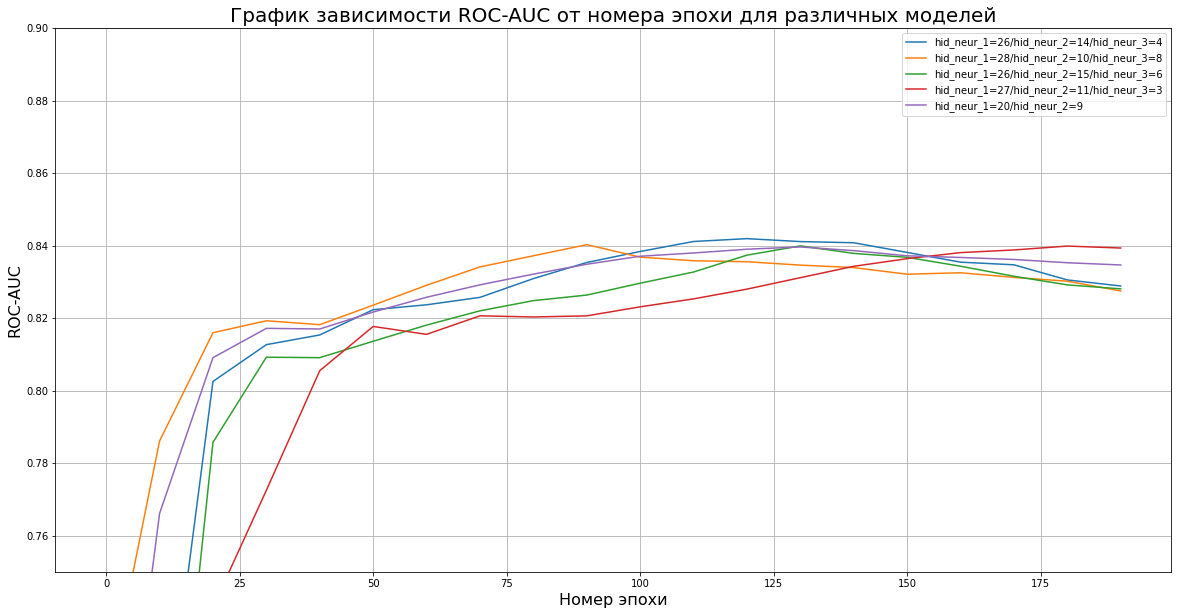

In [150]:
graph_auc_score(df_model_result[cols], 0.75, 0.9)

Таким образом мы получили, что наилучшей нейронной моделью является модель со следующими параметрами:
1. Модель имеет три скрытых слоя:
    * первый скрытый слой с 26 нейронами;
    * второй скрытый слой с 14 нейронами;
    * третий скрытый слой с 4 нейронами;
2. Функция актвации нейронов входного слоя и первых двух скрытых слоёв - ReLU, последний слой - логистическая.

Целевая метрика ROC-AUC для данной модели составила 0,841. Таким образом, внесём полученные данные в нашу сводную таблицу.

In [151]:
df_pivot.loc[k,'model'] = 'net'
df_pivot.loc[k,'ROC-AUC'] = df_model_result.max().sort_values(ascending=False).loc['hid_neur_1=26/hid_neur_2=14/hid_neur_3=4']

Дополнительно выполним окончательное обучение модели на полном наборе обучающих данных.

In [152]:
X_train = torch.FloatTensor(features_train.values)
y_train = torch.FloatTensor(target_train.values)

In [153]:
torch.manual_seed(RANDOM_STATE)    
class base_model(nn.Module):
    def __init__(self, in_neurons, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, out_neurons):
        super(base_model, self).__init__()
        self.fc1 = nn.Linear(in_neurons, hidden_neurons_1)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_neurons_2, hidden_neurons_3)
        self.ac3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_neurons_3, out_neurons)
        self.ac4 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        return x

net = base_model(in_neurons, 26, 14, 4, out_neurons)
        
net.apply(init_weights)
        
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
loss = nn.BCELoss()

num_epochs = 125
        
i = 0
        
for epoch in range(num_epochs):
    model_training(X_train, y_train)

### Выбор наилучшей модели

Для выбора наилучшей модели выведем на экран датафрейм, в который мы сводили данные по валидационной оценке датафреймов.

In [154]:
df_pivot

,model,ROC-AUC
0,model_rf,0.842923
1,model_cb,0.846017
2,net,0.841931


Из полученных данных мы видим, что с нашей задачей лучше всего справилась модель градиентного бустинга model_cb. Значение ROC-AUC для неё составил 0,846. Выберем данную модель в качестве наилучшей и протестируем.

### **Выводы**

1. По результатам выполнения пункта созданы три модели:
    1. Модель model_rf случайного леса;
    2. Модель model_cb на основе градиентного бустинга;
    3. Модель net на основе нейронных сетей.
2. Для всех моделей выполнена оценка метрики ROC-AUC. Данные были сведены в датафрейм df_pivot.
3. Дополнительно отметим, что для моделей model_rf и model_cb выполнена кросс-валидация, а для модели выполнена оценка только на одной валидационной выборке.
4. В качестве наилучшей модели выбрана модель градиентного бустинга model_cb. Значение ROC-AUC для неё составил 0,846.

## Тестирование модели

Получим предсказания наилучшей модели для тестовой выборки и определим значение метрики ROC-AUC.

In [155]:
predicts_test = model_cb.predict(test_data)
predicts_prob = model_cb.predict_proba(test_data)[:, 1]

In [156]:
auc_roc = roc_auc_score(target_test, predicts_prob)
acc = accuracy_score(target_test, predicts_test)
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 3))
print('Accuracy на тестовом наборе данных:', round(acc, 3))

AUC-ROC на тестовом наборе данных: 0.852
Accuracy на тестовом наборе данных: 0.801


Значение метрики ROC-AUC для тестовых данных составило 0,852, что удовлетворяет требованию задачи (значение метрики ROC-AUC для тестовых данных должно составлять не менее 0,85). При этом доля правильных ответов составляет 80,1% от общего количества оцениваемых данных (значение accuracy составило 0.801). Далее выполним дополнительный анализ результатов. Для начала построим ROC-кривую.

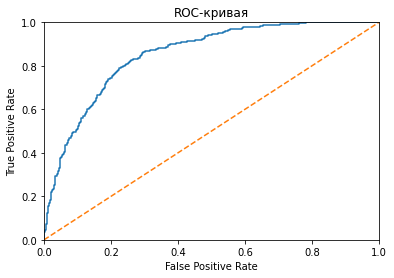

In [157]:
fpr, tpr, thresholds = roc_curve(target_test, predicts_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Дополнительно выведем матрицу ошибок.

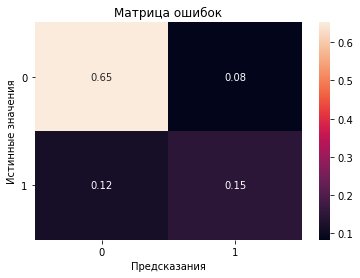

In [158]:
matrix = confusion_matrix(target_test, predicts_test)/len(target_test)

fig, ax = plt.subplots()
sns.heatmap(matrix, annot=True, fmt=".2f")

classes = ["0", "1"]
tick_marks = np.arange(len(classes)) + 0.5 
plt.xticks(tick_marks, classes, rotation=0) 
plt.yticks(tick_marks, classes, rotation=0)

plt.xlabel("Предсказания")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок")

plt.show()

Из полученной матрицы мы видим:
1. Для 80% клиентов мы предсказали верное значение ухода. Из них 15% клиентов компания смогла бы попробовать удержать путём проведения каких-либо индивидуальных акций;
2. Если бы компания проводила какие-либо индивидуальные акции для удержания клиентов, то для 8% клиентов это было бы излишне, и компания понисла бы для себя дополнительные расходы;
3. Если бы компания проводила какие-либо индивидуальные акции для удержания клиентов, то для 12% клиентов она бы их всё равно не предложила бы и клиенты ушли бы.

Стоит отметить, что в случае, если для компании удержание клиента является более приоритетной задачей, чем излишние расходы на акции, то нам следовало бы повысить метрику Recall и понизить метрику Precision (но в разумных пределах).

Для оценки потенциальной возможности повышения метрики Recall выведем на экран PR-даиграмму.

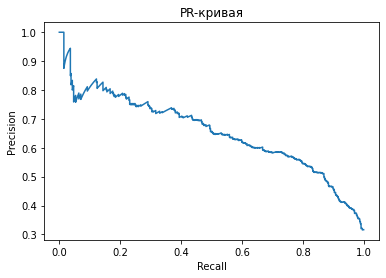

In [159]:
precision, recall, threshold = precision_recall_curve(target_test, predicts_prob)

plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')

plt.show()

Из полученного графика вино, что метрику Recall можно довести до 0,7...0,8, так как при дальнейшем её увеличении идёт более интенсивное снижение метрики Precision. Однако, для принятие окончательного решения необходимо проводить бизнес-оценку с учётом затрат на проведение акций и дохода, получаемого с каждого клиента. Данная задача уже лежит за рамками данного проекта.

Дополнительно выведем на экран важность признаков для принятия решения по целевой метрики.

In [160]:
feature_importance = model_cb.get_feature_importance(test_data, type='PredictionValuesChange')

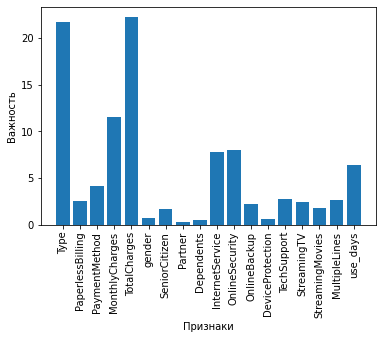

In [161]:
fig, ax = plt.subplots()
ax.bar(features_test_cb.columns.tolist(), feature_importance)
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность')
plt.xticks(rotation='vertical')
plt.show()

Из полученной диаграммы видно, что наиболее важным признаком для модели являются общие расходы абонента на услуги. Для оценки влияния данного признака выведем на экран диаграмму распределения данных для двух типов клиентов.

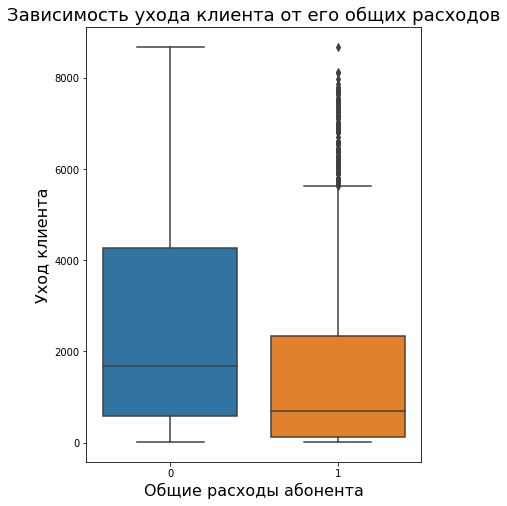

In [162]:
plt.figure(figsize=(6, 8))
sns.boxplot(data=df, x="termination", y='TotalCharges')
plt.xlabel('Общие расходы абонента', fontsize=16)
plt.ylabel('Уход клиента', fontsize=16)
plt.title('Зависимость ухода клиента от его общих расходов', fontsize=18)
plt.show()

Из полученного графика мы видим, что вероятность ухода клиента тем выше, чем меньше его общие расходы на услуги. Вероятно, что клиенты, которые имеют меньшие расходы более заинтересованы в экономии средств и при появлении более дешёвых предложений, не упускают выгоду.

***Выводы***
1. При тестировании наилучшей модели значение метрики ROC-AUC составило 0,852, что удовлетворяет требованию задачи (значение метрики ROC-AUC для тестовых данных должно составлять не менее 0,85). Доля правильных ответов составила 80,1% от общего количества оцениваемых данных;
2. При оценке матрицы ошибок для тестовых данных установлено:
    * Для 80% клиентов мы предсказали верное значение ухода. Из них 15% клиентов компания смогла бы попробовать удержать путём проведения каких-либо индивидуальных акций;
    * Если бы компания проводила какие-либо индивидуальные акции для удержания клиентов, то для 8% клиентов это было бы излишне, и компания понисла бы для себя дополнительные расходы;
    * Если бы компания проводила какие-либо индивидуальные акции для удержания клиентов, то для 12% клиентов она бы их всё равно не предложила бы и клиенты ушли бы.
3. В случае, если для компании удержание клиента является более приоритетной задачей, чем излишние расходы на акции, то потенциальная возможность повышения метрик Recall до 0.7...0.8, так как при дальнейшее её увеличение ведёт к более интенсивному снижению метрики Precision. Однако, для принятие окончательного решения необходимо проводить бизнес-оценку с учётом стоимости акций и дохода, получаемого с каждого клиента. Данная задача уже лежит за рамками данного проекта.
4. Наиболее важным признаком для принятия моделью решения являются общие расходы абонента. Чем они меньше, тем больше вероятность того, что клиент уйдёт. Вероятно это связано с тем, что клиенты, которые имеют меньшие расходы более заинтересованы в экономии средств и при появлении более дешёвых предложений, не упускают выгоду.

## Общий вывод

1. В ходе выполнения предварительного анализа данных:
    1. Было выявлено, что в исходных датафреймах аномальные значения отсутствовали. Было выполнено объединение датафреймов по столбцу "customerID" в один и созданы дополнительные столбцы:
        * Столбец с целевым признаком termination;
        * Дополнительный столбец признак use_days с количеством дней предоставления услуг пользователю;        
    2. Строки, в которые дата заключения договора совпадала с датой актуализации таблицы были исключены, так как по ним невозможно сделать оценку ухода клиента;
    3. Пропуска в датафрейме имелись только в столбцах с информацией о подключении клиентом дополнительных услуг. Эти пропуска были заполнены категорией "no_info";
    4. Предварительно выполнена оценка потенциальной опасности ухода клиента. По результатам этой оценки установлено, что потенциальная угроза ухода клиента выше если он:
        * Выполняет оплату услуги ежемесячно;
        * Использует электронный счёт и пользуется электронным чеком;
        * Является пенсионером;
        * Не имеет супруга/супруги;
        * Подключил услугу по оптической системе передачи данных, блокировку опасных сайтов, облачное хранилище файлов для резервного копирования данных или многоканальную линию связи;
        * Не подключал антивирус или выделенную линию техподдержки;
        * Осуществляет среднемесячный платёж больше среднего, а годовой наоборот - меньше.
    5. По результатам оценки Фк корреляции определены следующие основные особенности корреляций:
        * Имеется коррекляция между признаками "use_days", "BeginDate", "termination" и "EndDate". Данная корреляция связана с тем, что столбцы "use_days" и "termination" созданы на основе столбцов "BeginDate" и "EndDate". Таким образом, что бы избежать утечки мы оставим только обучающий признак "use_days" и целевой "termination".
        * Суммы ежемесечного и годовых платежей достаточно коррелируют с набором услуг, которые подключил клиент. При такой корреляции утечки по целевому признаку не наблюдаются.
2. Для ешения поставленной задачи были созданы три модели с подбором гиперпараметров:
    1. Модель model_rf случайного леса;
    2. Модель model_cb на основе градиентного бустинга;
    3. Модель net на основе нейронных сетей.
3. Для всех моделей была выполнена оценка метрики ROC-AUC, величина которой составила:
    1. Для модели model_rf - 0,842;
    2. Для модели model_cb - 0,846;
    3. Для модели net - 0,841.
4. В качестве наилучшей модели выбрана модель градиентного бустинга model_cb. Значение ROC-AUC для неё составил 0,846.
5. При тестировании наилучшей модели значение метрики ROC-AUC составило 0,852, что удовлетворяет требованию задачи (значение метрики ROC-AUC для тестовых данных должно составлять не менее 0,85). Доля правильных ответов составила 80,1% от общего количества оцениваемых данных;
6. При оценке матрицы ошибок для тестовых данных установлено:
    * Для 80% клиентов мы предсказали верное значение ухода. Из них 15% клиентов компания смогла бы попробовать удержать путём проведения каких-либо индивидуальных акций;
    * Если бы компания проводила какие-либо индивидуальные акции для удержания клиентов, то для 8% клиентов это было бы излишне, и компания понисла бы для себя дополнительные расходы;
    * Если бы компания проводила какие-либо индивидуальные акции для удержания клиентов, то для 12% клиентов она бы их всё равно не предложила бы и клиенты ушли бы.
7. В случае, если для компании удержание клиента является более приоритетной задачей, чем излишние расходы на акции, то потенциальная возможность повышения метрик Recall до 0.7...0.8, так как при дальнейшее её увеличение ведёт к более интенсивному снижению метрики Precision. Однако, для принятие окончательного решения необходимо проводить бизнес-оценку с учётом стоимости акций и дохода, получаемого с каждого клиента. Данная задача уже лежит за рамками данного проекта.
8. Наиболее важным признаком для принятия моделью решения являются общие расходы абонента. Чем они меньше, тем больше вероятность того, что клиент уйдёт. Вероятно это связано с тем, что клиенты, которые имеют меньшие расходы более заинтересованы в экономии средств и при появлении более дешёвых предложений, не упускают выгоду.